<h1 style="font-family:Corbel Light; color:#e54b87">Projet 4 : Anticipez les besoins en consommation de bâtiments </h1>

<h2 style="font-family:Corbel Light; color:#737373">Requirements</h2>

In [108]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import scipy
from scipy.stats import uniform
from scipy.stats import randint

import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LearningCurveDisplay
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, RobustScaler, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.compose import TransformedTargetRegressor

import category_encoders
from category_encoders.target_encoder import TargetEncoder

import hyperopt
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope

import xgboost as xgb
import catboost as ctb

import shap
import toolbox
from functools import partial
from math import ceil

%matplotlib inline
pd.options.display.float_format = '{:_.5f}'.format
shap.initjs()

In [109]:
python_version = !python -V
print('python version : ', python_version,'\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('scikit-learn version : ', sklearn.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('XGBoost version : ', xgb.__version__, '\n')
print('CatBoost version : ', ctb.__version__, '\n')
print('SHAP version : ', shap.__version__, '\n')
print('scipy version : ', scipy.__version__, '\n') 
print('hyperopt version : ', hyperopt.__version__, '\n') 
print('category_encoder version : ', category_encoders.__version__)

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.5 

matplotlib version :  3.5.1 

scikit-learn version :  1.2.1 

seaborn version :  0.12.1 

XGBoost version :  1.7.2 

CatBoost version :  1.1.1 

SHAP version :  0.41.0 

scipy version :  1.9.1 

hyperopt version :  0.2.7 

category_encoder version :  2.5.1.post0


**Versions utilisées :**

- python : Python 3.9.12
- scikit-learn  :  1.1.3  
- seaborn    :  0.12.1
- matplotlib :  3.5.1 
- numpy  :  1.21.5 
- pandas :  1.4.2
- TensorFlow :  2.11.0
- SHAP :  0.41.0
- CatBoost : 1.1.1
- XGBoost : 1.7.2
- scipy :  1.9.1 
- hyperopt :  0.2.7 
- category_encoder version : 2.5.1.post0

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Étape 2</span> : Modélisation (Cible : Consommation d'énergie)</h2>

<h3 style="font-family:Corbel Light; color:#737373">Inspection des données</h3>

In [110]:
data_building = pd.read_pickle('2016_Building_Energy_Benchmarking_Cleaned.pkl')

In [111]:
data_building.head()

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,NumberofFloors,NumberofBuildings,YearBuilt,Neighborhood,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),PropertyGFABuilding(s)
0,88434,88_434.00000,0.00000,0.00000,Hotel,NaN,NaN,12,1.00000,1927,downtown,60.00000,7_226_362.50000,249.98000,1_276_453.00000,3_946_027.00000,2_003_882.00000,88434
1,103566,83_880.00000,15_064.00000,4_622.00000,Hotel,Parking,Restaurant,11,1.00000,1996,downtown,61.00000,8_387_933.00000,295.86000,5_145_082.00000,3_242_851.00000,0.00000,88502
2,956110,756_493.00000,0.00000,0.00000,Hotel,NaN,NaN,41,1.00000,1969,downtown,43.00000,72_587_024.00000,2_089.28000,1_493_800.00000,49_526_664.00000,21_566_554.00000,759392
3,61320,61_320.00000,0.00000,0.00000,Hotel,NaN,NaN,10,1.00000,1926,downtown,56.00000,6_794_584.00000,286.43000,1_811_213.00000,2_768_924.00000,2_214_446.25000,61320
4,175580,123_445.00000,68_009.00000,0.00000,Hotel,Parking,Swimming Pool,18,1.00000,1980,downtown,75.00000,14_172_606.00000,505.01000,8_803_998.00000,5_368_607.00000,0.00000,113580


In [112]:
data_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyGFATotal                 989 non-null    int64  
 1   LargestPropertyUseTypeGFA        989 non-null    float64
 2   SecondLargestPropertyUseTypeGFA  989 non-null    float64
 3   ThirdLargestPropertyUseTypeGFA   989 non-null    float64
 4   LargestPropertyUseType           989 non-null    object 
 5   SecondLargestPropertyUseType     488 non-null    object 
 6   ThirdLargestPropertyUseType      151 non-null    object 
 7   NumberofFloors                   989 non-null    int64  
 8   NumberofBuildings                989 non-null    float64
 9   YearBuilt                        989 non-null    int64  
 10  Neighborhood                     989 non-null    object 
 11  ENERGYSTARScore                  989 non-null    float64
 12  SiteEnergyUse(kBtu)   

On a 5 variables catégorielles : 

- A convertir en numérique : 
    - LargestPropertyUseType
    - Neighborhood


- A utiliser pour créer de nouvelles variables : 
    - YearBuilt 
    - SecondLargestPropertyUseType
    - ThirdLargestPropertyUseType

<h3 style="font-family:Corbel Light; color:#737373">Création de nouvelles variables</h3>

In [113]:
data_building_new = data_building.drop(columns=['PropertyGFABuilding(s)'])

<h4 style="font-family:Corbel Light; color:#737373">Sources et proportions d'énergie</h4>

In [114]:
print("valeurs nulles dans 'Electricity(kBtu)' :",
      data_building_new.loc[data_building_new['Electricity(kBtu)'] == 0.0].shape[0])

valeurs nulles dans 'Electricity(kBtu)' : 0


In [115]:
data_building_new['EnergyMixRatio'] = data_building_new.apply(lambda row: abs((row['SteamUse(kBtu)'] + row['NaturalGas(kBtu)'])/row['Electricity(kBtu)'])
                                                              if row['Electricity(kBtu)'] != 0 else 0, axis=1)

In [116]:
data_building_new[['EnergyMixRatio']].sample(5)

,EnergyMixRatio
23,1.61023
192,0.00000
631,1.10218
90,0.55520
398,0.17388


Remarques : 
- on obtient de meilleurs résultats avec la variable 'EnergyMixRatio' (rapport entre conso d'autres sources et d'électricité) qu'en utilisant les proportions de chaque source d'énergie.

In [117]:
data_building_new.drop(columns=['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)'],
                       inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Ancienneté du bâtiment</h4>

On remplace la date de construction du bâtiment par son âge en 2016

In [118]:
data_building_new['AgeBuilding'] = 2016 - data_building_new['YearBuilt']
data_building_new[['YearBuilt', 'AgeBuilding']].head()

,YearBuilt,AgeBuilding
0,1927,89
1,1996,20
2,1969,47
3,1926,90
4,1980,36


Remarque : regrouper les années de construction n'améliore pas les résultats

In [119]:
data_building_new.drop(columns=['YearBuilt'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Nombre de bâtiments et d'étages</h4>

On va transformer ces variables numériques en variables catégorielles ordinales, en regroupant les valeurs avec un effectif très faible

On va regrouper les biens immobiliers par taille totale : 
- large : > 100K square feet
- mid-size : 20K-100K square feet
- small  : < 20K square feet

In [120]:
def group_size(row: np.array):
    if row['PropertyGFATotal'] <= 100_000:
        size_n = 'SmallMidSize'
    else:
        size_n = "Large"

    return size_n

In [121]:
data_building_new['PropertySize'] = data_building_new.apply(lambda row: group_size(row), axis=1)
data_building_new['PropertySize'].value_counts(normalize=True).sort_index()

Large          0.30940
SmallMidSize   0.69060
Name: PropertySize, dtype: float64

On va regrouper les bâtiments par nombre d'étage:

- low-rise : 4 étages ou moins
- mid rise : 5 à 9 étages
- high rise : 10 étages ou plus 

In [122]:
def group_floors(row: np.array):
    floor_n = row['NumberofFloors']
    if row['NumberofFloors'] == 0:
        floor_n = 1
    elif row['NumberofFloors'] > 4:
        if row['NumberofFloors'] < 10:
            floor_n = 5
        else:
            floor_n = 10

    return floor_n

In [123]:
data_building_new['NumberofFloors'].value_counts(normalize=True).sort_index()

0    0.01011
1    0.25379
2    0.19717
3    0.14863
4    0.09403
5    0.07583
6    0.05359
7    0.02831
8    0.01314
9    0.00708
10   0.01618
11   0.01416
12   0.00809
13   0.00506
14   0.00809
15   0.00506
16   0.00303
17   0.00404
18   0.00303
19   0.00404
20   0.00303
21   0.00303
22   0.00303
23   0.00303
24   0.00303
25   0.00303
27   0.00101
28   0.00101
29   0.00303
30   0.00101
33   0.00303
34   0.00202
36   0.00202
37   0.00101
41   0.00202
42   0.00506
46   0.00101
47   0.00101
49   0.00101
55   0.00101
56   0.00101
63   0.00101
76   0.00101
99   0.00101
Name: NumberofFloors, dtype: float64

In [124]:
data_building_new['NumberofFloors'] = data_building_new.apply(lambda row: group_floors(row), axis=1)

In [125]:
data_building_new['NumberofFloors'].value_counts(normalize=True).sort_index()

1    0.26390
2    0.19717
3    0.14863
4    0.09403
5    0.17796
10   0.11830
Name: NumberofFloors, dtype: float64

De même pour le nombre de bâtiments dans une même propriété

In [126]:
data_building_new['NumberofBuildings'].value_counts()

1.00000    953
0.00000     24
2.00000      3
4.00000      2
6.00000      2
9.00000      1
7.00000      1
5.00000      1
3.00000      1
8.00000      1
Name: NumberofBuildings, dtype: int64

In [127]:
data_building_new['NumberofBuildings'] = data_building_new.apply(
    lambda row: 2 if row['NumberofBuildings'] > 1 else row['NumberofBuildings'], axis=1)

In [128]:
data_building_new['NumberofBuildings'].value_counts()

1.00000    953
0.00000     24
2.00000     12
Name: NumberofBuildings, dtype: int64

Rmq : il semblerait que les variables : NumberofBuildings et NumberofFloors ne soient pas très utilisées par les modèles, on les supprime.

In [129]:
data_building_new.drop(columns=['NumberofBuildings', 'NumberofFloors'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Fonctions des bâtiments</h4>

On va regrouper les fonctions des biens immobiliers pour ne pas avoir de fonction avec un effectif inférieur à 1% , étant donné qu'on a peu d'observations (pour limiter le surapprentissage). 

On les regroupe par "efficience énergétique" (voir notebook "Analyse" partie "Etude du dataset -> Consommation d'énergie -> Efficacité Energétique") 

- 'worst' = fonctions qui consomment beaucoup pour leur taille 
- 'best'=  fonctions qui consomment peu pour leur taille
- etc...

In [130]:
energy_efficiency = {'Worst': ['Hospital (General Medical & Surgical)', 'Data Center',
                               'Supermarket/Grocery Store', 'Convenience Store without Gas Station',
                               'Other/Specialty Hospital', 'Laboratory', 'Refrigerated Warehouse',
                               'College/University', 'University'],
                     'Low': ['Wholesale Club/Supercenter', 'Courthouse', 'Senior Care Community',
                             'Bank Branch', 'Financial Office', 'Hotel', 'Medical Office', 'Parking', 'Swimming Pool',
                             'Other - Services', 'Food Service', 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
                             'Manufacturing/Industrial Plant', 'Other - Technology/Science',
                             'Restaurant', 'Other - Restaurant/Bar'],
                     'MidOffice': ['Office'],
                     'MidOther': ['Other', 'Retail Store', 'Performing Arts', 'Other - Entertainment/Public Assembly',
                                  'Fitness Center/Health Club/Gym', 'Other - Recreation', 'Social/Meeting Hall',
                                  'Bar/Nightclub', 'K-12 School', 'Pre-school/Daycare',
                                  'Adult Education', 'Other - Education', 'Residence Hall/Dormitory',
                                  ],
                     'High': ['Distribution Center', 'Worship Facility', 'Self-Storage Facility'],
                     'Best': ['Non-Refrigerated Warehouse', 'Multifamily Housing']
                     }

In [131]:
data_building_new['LargestPropertyUseTypeGrouped'] = 'MidOther'

for efficiency, property_types in energy_efficiency.items():
    data_building_new['LargestPropertyUseTypeGrouped'] = data_building_new.apply(lambda row: efficiency
                                                                                 if row['LargestPropertyUseType'] in property_types
                                                                                 else row['LargestPropertyUseTypeGrouped'], axis=1)

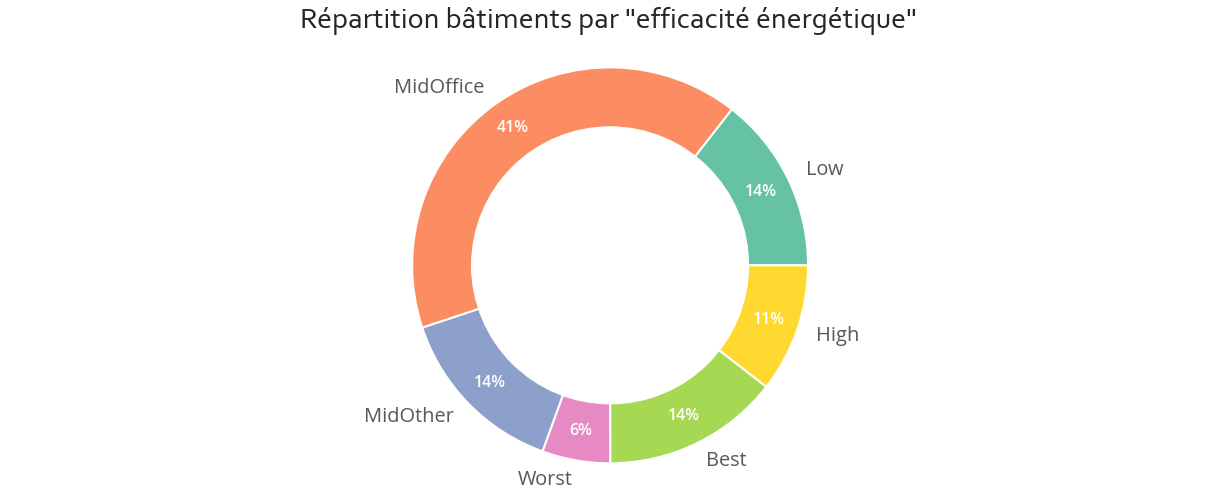

In [132]:
toolbox.plot_donut(data_building_new, 'LargestPropertyUseTypeGrouped', 'Set2',
                   '#595959', 'Répartition bâtiments par "efficacité énergétique"', (17, 7))

On va créer une variable pour chacune de ces nouvelles catégories, dans laquelle on mettra la surface utilisée 

Rmq: Pour cette cible, il semblerait que l'on obtienne de meilleurs résultats en utilisant directement la surface (ex: 1000 sq.ft. d'hôtel) plutôt que le pourcentage de surface totale (ex: 30% d'hôtel)

In [133]:
def usetype_gfa(row: pd.Series, property_types: [str]):
    type_gfa = 0

    if row['LargestPropertyUseType'] in property_types:
        type_gfa += row['LargestPropertyUseTypeGFA']
    if row['SecondLargestPropertyUseType'] in property_types:
        type_gfa += row['SecondLargestPropertyUseTypeGFA']
    if row['ThirdLargestPropertyUseType'] in property_types:
        type_gfa += row['ThirdLargestPropertyUseTypeGFA']

    return type_gfa


for energy_efficiency, type_list in energy_efficiency.items():
    data_building_new[energy_efficiency + 'EfficiencyGFA'] = data_building_new.apply(
        lambda row: usetype_gfa(row, type_list), axis=1)

In [134]:
data_building_new.drop(columns=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
                                'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
                                'LargestPropertyUseTypeGrouped', 'PropertyGFATotal'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Localisation</h4>

In [135]:
data_building_new['Neighborhood'].value_counts(normalize=True)

downtown                0.24469
greater duwamish        0.20222
lake union              0.10111
magnolia / queen anne   0.08696
northeast               0.08089
east                    0.06572
northwest               0.05561
ballard                 0.03640
north                   0.03438
delridge                0.02730
central                 0.02528
southeast               0.02123
southwest               0.01820
Name: Neighborhood, dtype: float64

Aucun quartier en dessous de 1% donc on peut tous les garder sans les regrouper

<h4 style="font-family:Corbel Light; color:#737373">Etude des nouvelles variables</h4>

<h5 style="font-family:Corbel Light; color:#737373">Corrélations linéaires</h5>

On regarde s'il existe des corrélations linéaires entre les nouvelles variables. Le but étant de ne pas garder de variables avec une corrélation linéaire supérieure à 0.6 car : 
- les 2 variables apporteraient la même info, or avoir beaucoup de variables alors qu'on a peu d'observations augmente le risque de surapprentissage

- dans les modèles linéaires (en particulier la régression linéaire) si les variables sont corrélées -> risque de surapprentissage car :
    - l'interprétation de l'effet de la variable sur la prédiction sera plus difficile car non direct (le fait de modifier x1 va entrainer des  modifications sur les autres variables qui lui sont corrélées)
    - la solution ne sera pas unique (modèle instable avec plusieurs solutions possibles)
    - les coefficients des variables corrélées seront instables/ d'une grande variabilité (car vont dépendre les uns des autres et une modification de la valeur de l'un peut être compensée par une variation de la valeur des autres)
    
    rmq : si on applique une régularisation l1 au modèle pour limiter le surapprentissage (lasso), permet d'être plus parcimonieux et de ne garder qu'une seule des variables corrélées au hasard (mais donne solution instable).

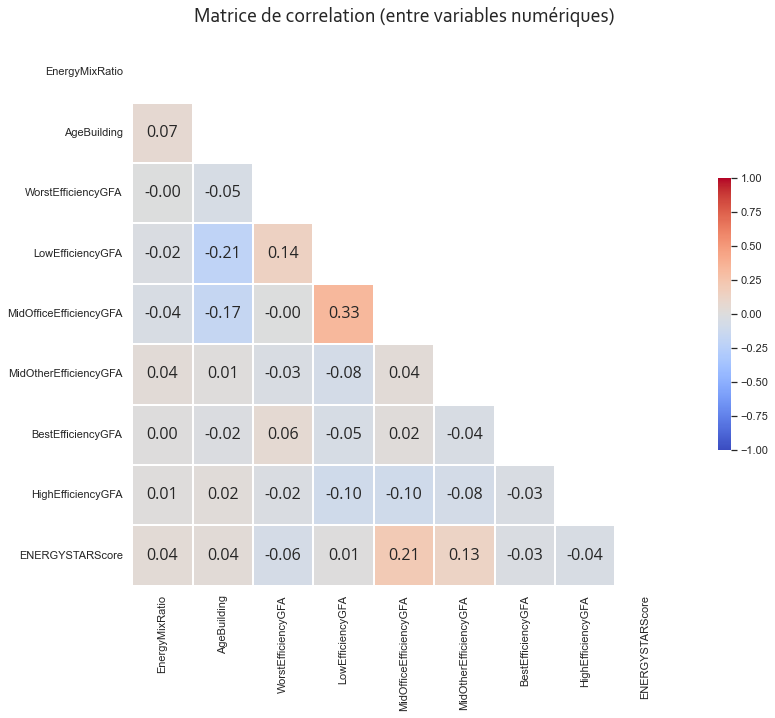

In [136]:
feature_numeric = ['EnergyMixRatio', 'AgeBuilding', 'WorstEfficiencyGFA',
                   'LowEfficiencyGFA', 'MidOfficeEfficiencyGFA',
                   'MidOtherEfficiencyGFA', 'BestEfficiencyGFA',
                   'HighEfficiencyGFA', 'ENERGYSTARScore']

correlation_matrix = data_building_new[feature_numeric].corr()

toolbox.plot_heatmap_correlation_matrix(correlation_matrix,
                                        'Matrice de correlation (entre variables numériques)',
                                        (15, 10), 'coolwarm')

<h5 style="font-family:Corbel Light; color:#737373">Distributions</h5>

On regarde la distribution des nouvelles variables numériques : aucune ne semble gaussienne 

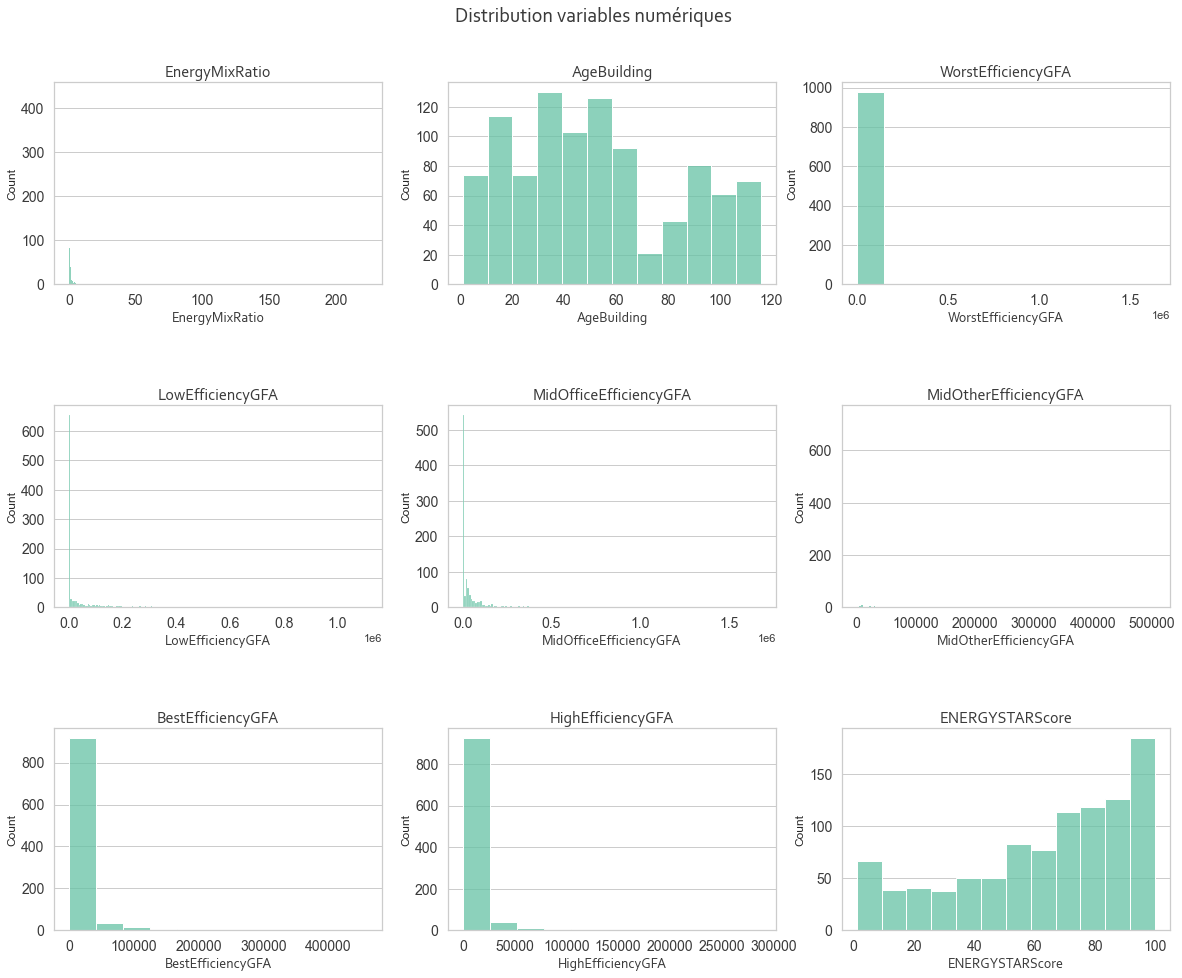

In [30]:
toolbox.display_distribution(data_building_new, feature_numeric, 3, (20, 15), hspace=0.6, top=0.91)

<h5 style="font-family:Corbel Light; color:#737373">Test transformations</h5>

Testons différentes transformations : le but étant de se rapprocher le plus possible d'une loi normale pour aider certains modèles à apprendre et à aller plus vite. En particulier les modèles linéaires qui auront une solution plus stable car on va essayer de réduire la variance des variables (en réduisant l'impact des valeurs extrêmes).

*rmq : Les modèles ensemblistes qui utilisent des arbres (xgboost, gboost, forêt aléatoire) ne sont pas affectés par la forme de la distribution des variables ni par leur ordre de grandeur (variables exprimées dans des unités différentes).*

Le passage au logarithme est censé mieux fonctionner sur les variables avec une asymétrie positive (i.e. étalées sur la droite - skew > 0). 

En effet on voit qu'il ne fonctionne pas du tout sur les variables 'Age Building' et 'ENERGYSTARScore'. 
- AgeBuilding: l'asymétrie a changé de sens et est plus prononcée
- ENERGYSTARScore : l'asymétrie est encore plus forte

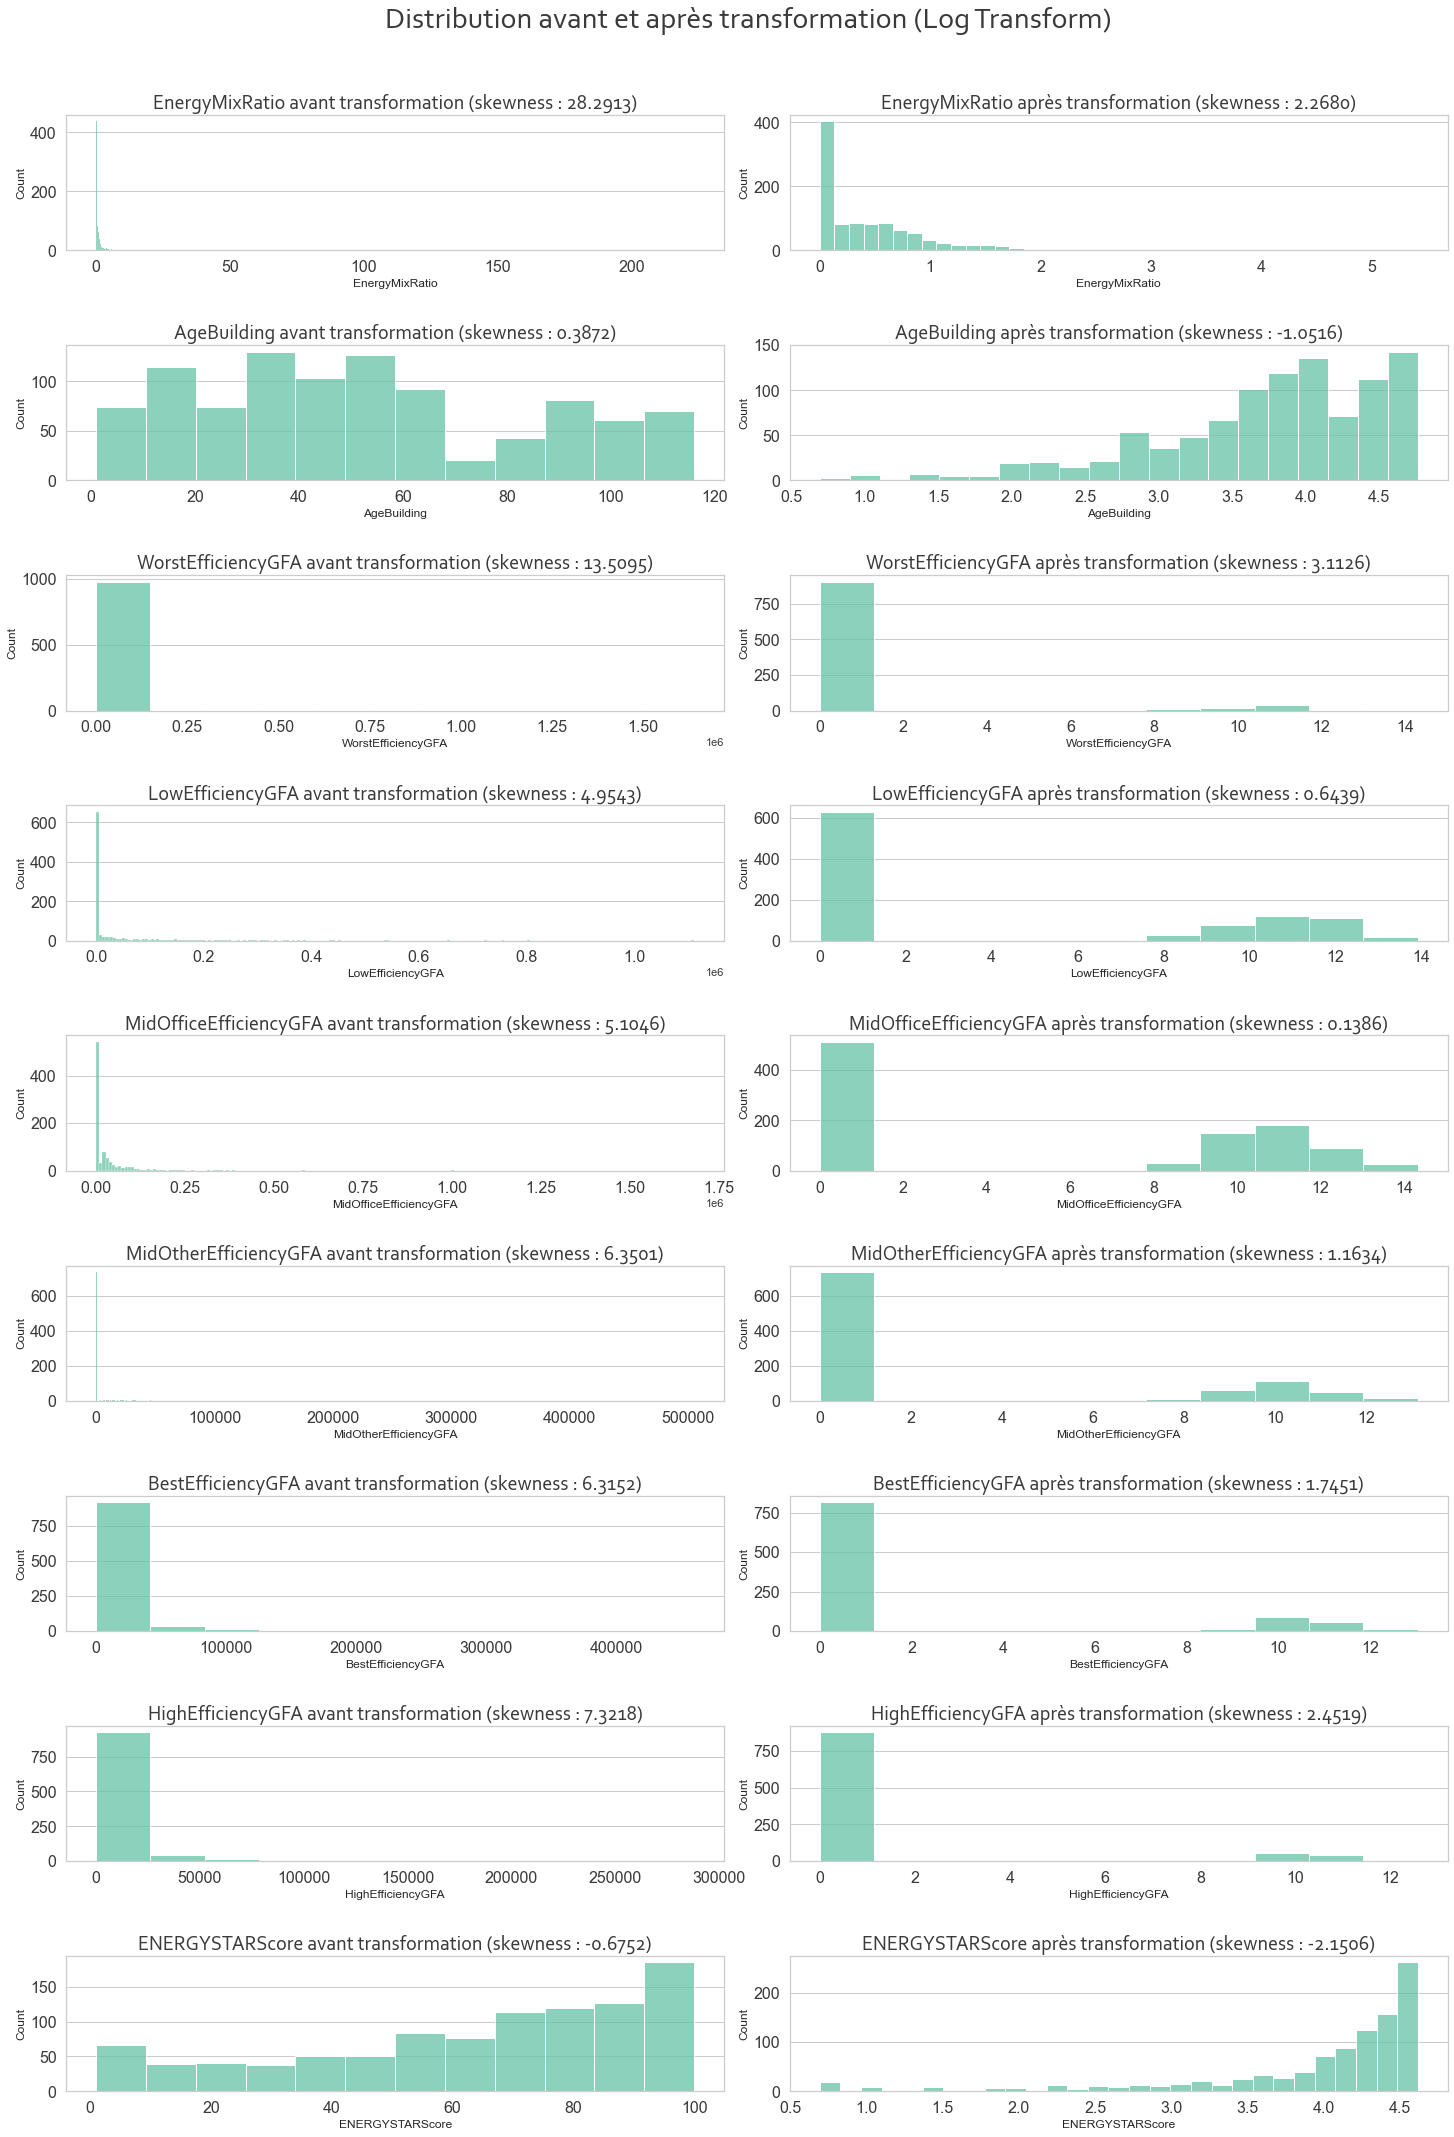

In [31]:
toolbox.test_transformer(data_building_new,
                         feature_numeric,
                         [FunctionTransformer(np.log1p)],
                         'Log Transform',
                         (20, 30), top=0.93
                         )

Pour l''ENERGYSTARScore' qui présente une asymétrie négative (étalée sur la gauche - skew<0) on peut essayer d'appliquer un passage au carré.

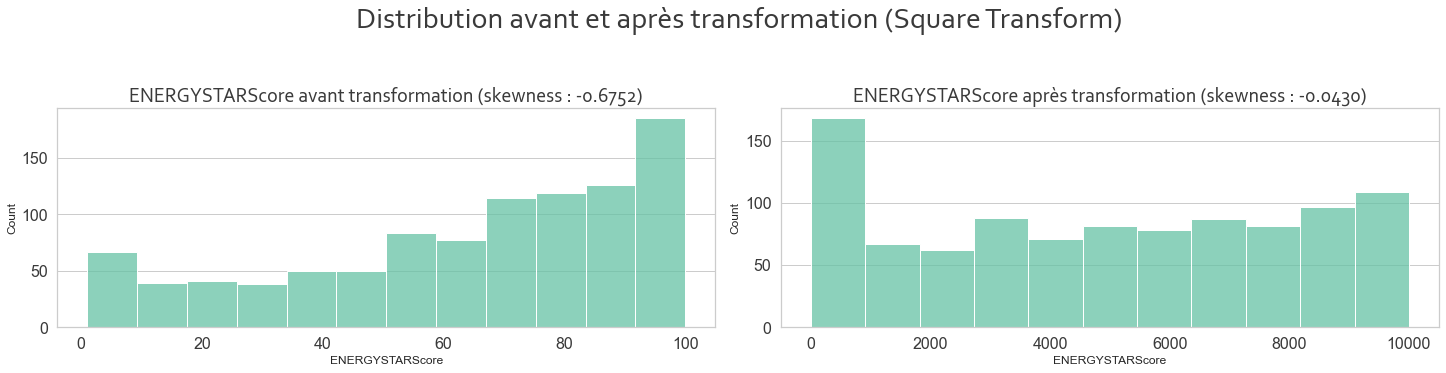

In [32]:
toolbox.test_transformer(data_building_new, ['ENERGYSTARScore'],
                         [FunctionTransformer(np.square)],
                         'Square Transform',
                         (20, 5), top=0.7
                         )

Pour les autres variables on peut essayer de voir si la méthode de Yeo-Johnson fonctionne mieux que le passage au logarithme. La formule est la suivante : 

\begin{cases}((x_{i}+1)^{\lambda }-1)/\lambda &{\text{si }}\lambda \neq 0,x_{i}\geq 0\\\log(x_{i}+1)&{\text{si }}\lambda =0,x_{i}\geq 0\\-[(-x_{i}+1)^{(2-\lambda )}-1]/(2-\lambda )&{\text{si }}\lambda \neq 2,x_{i}<0\\-\log(-x_{i}+1)&{\text{si }}\lambda =2,x_{i}<0\end{cases}

rmq : pour chaque variable, sklearn utilise le lambda qui maximise la vraisemblance

- Pour AgeBuilding on voit que l'asymétrie a de nouveau changée de sens mais la skewness est moins forte
- Pour les autres variables c'est un peu mieux ou pareil

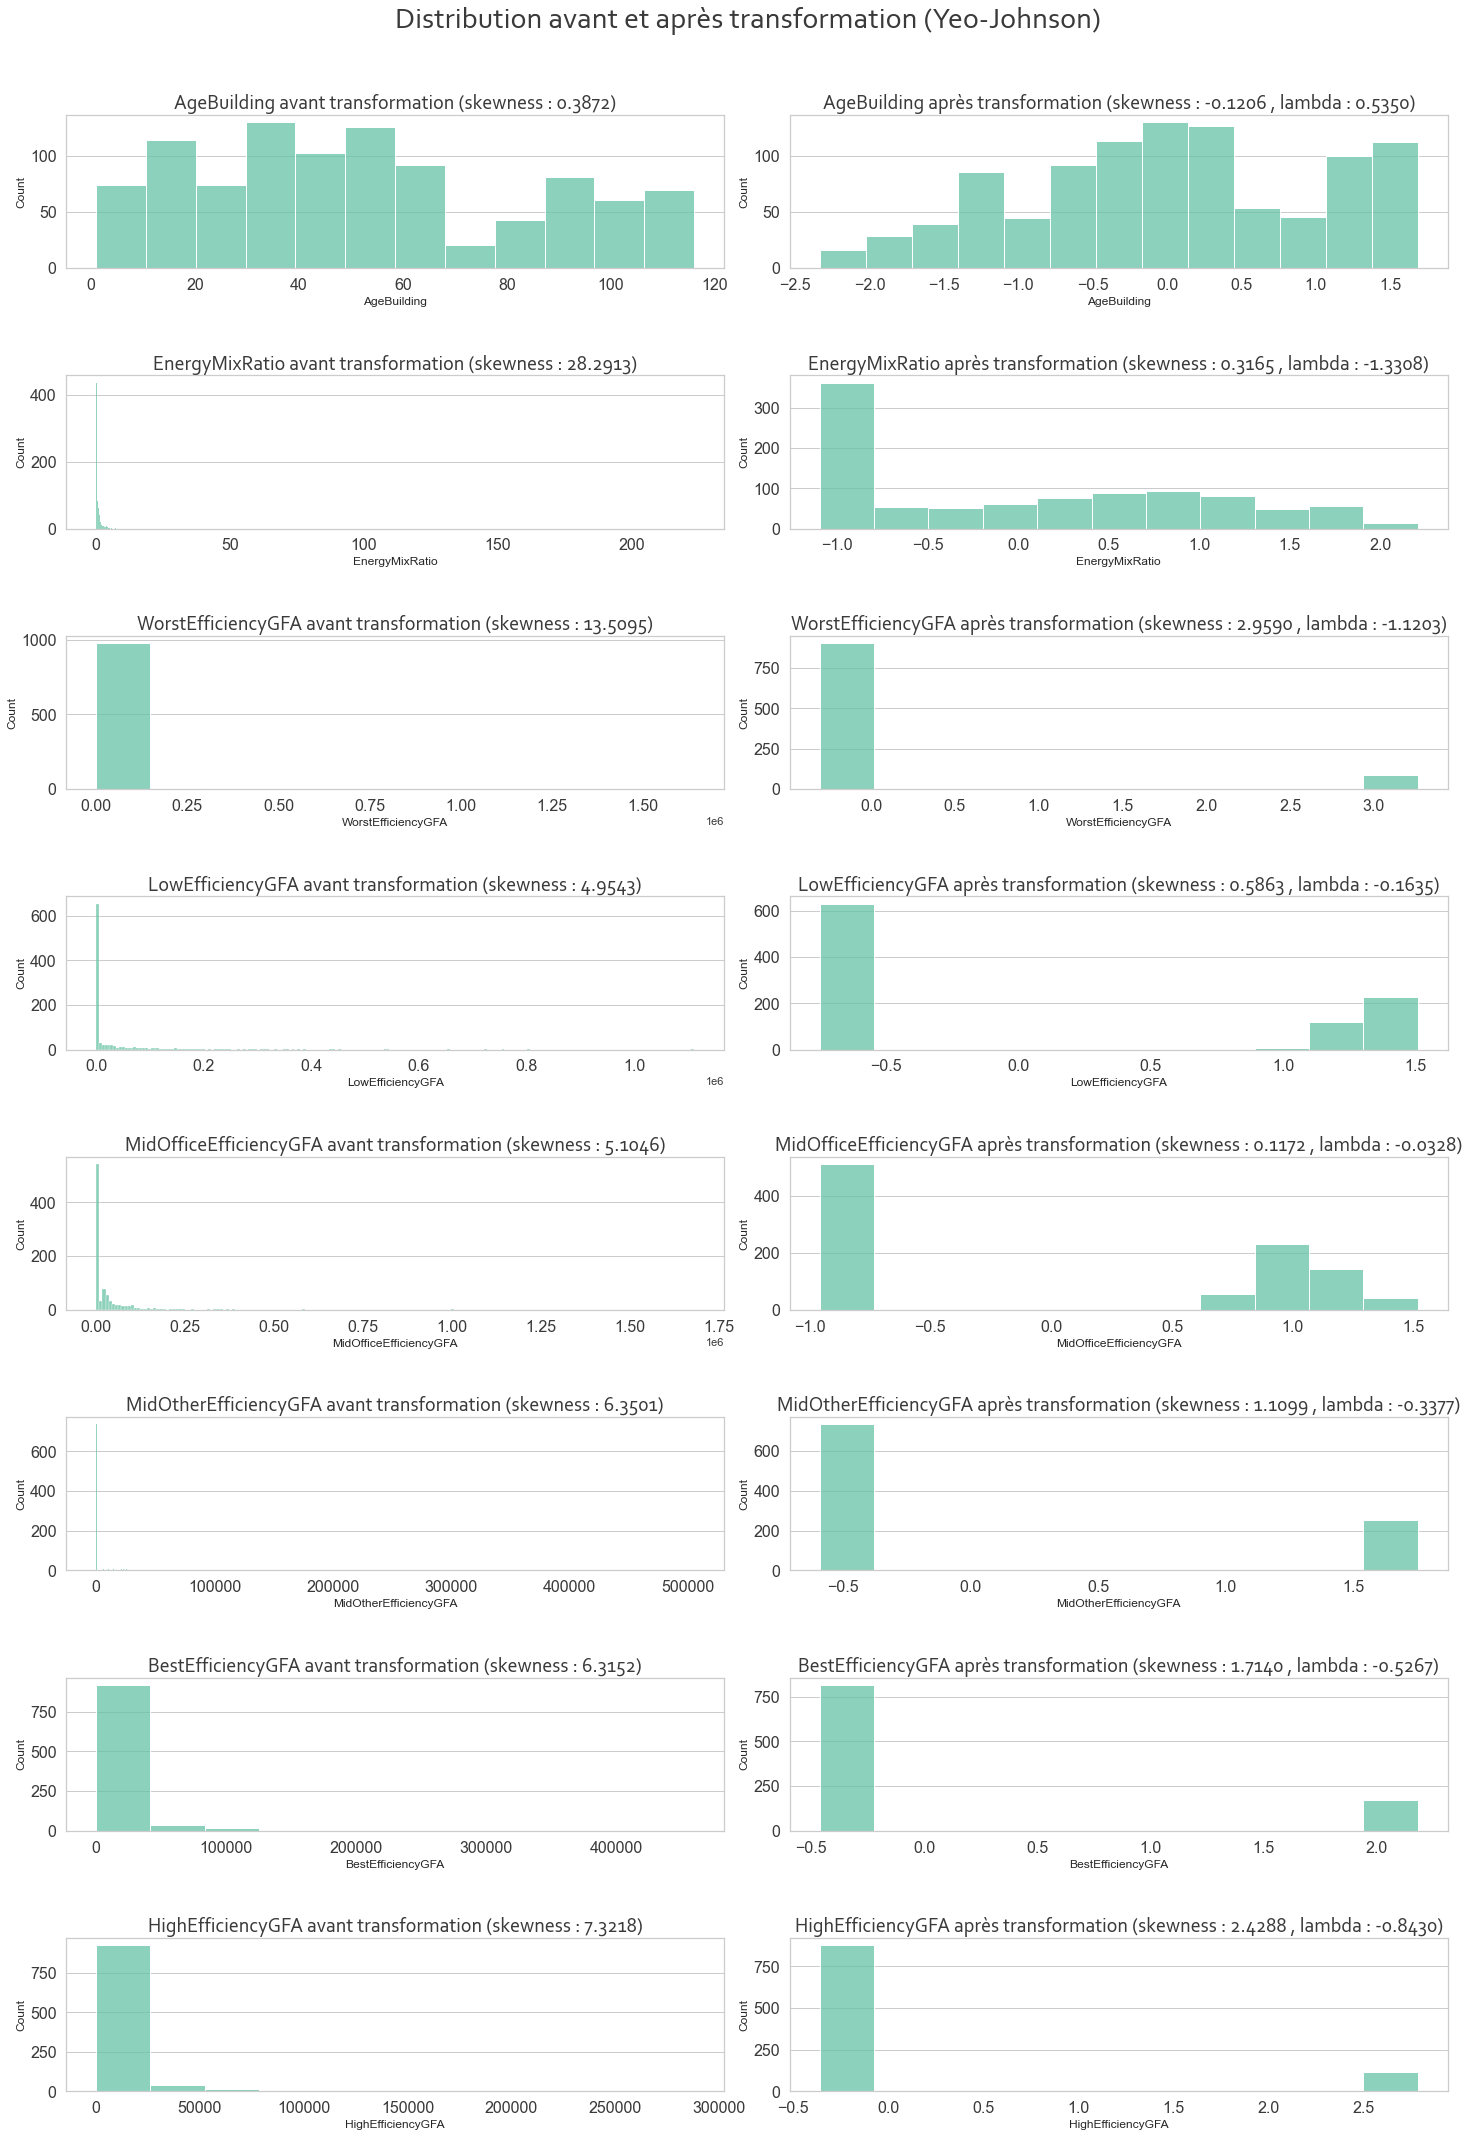

In [33]:
toolbox.test_transformer(data_building_new,
                         ['AgeBuilding', 'EnergyMixRatio',
                          'WorstEfficiencyGFA', 'LowEfficiencyGFA',
                          'MidOfficeEfficiencyGFA', 'MidOtherEfficiencyGFA',
                          'BestEfficiencyGFA', 'HighEfficiencyGFA'],
                         [PowerTransformer(standardize=True)],
                         'Yeo-Johnson',
                         (20, 30),
                         top=0.93
                         )

<h3 style="font-family:Corbel Light; color:#737373">Préparation des données</h3>

In [137]:
X = data_building_new.drop(columns=['ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
y = data_building_new['SiteEnergyUse(kBtu)']

In [138]:
X.shape

(989, 11)

<h4 style="font-family:Corbel Light; color:#737373">Choix des transformations </h4>

<h5 style="font-family:Corbel Light; color:#737373">Pipeline</h5>

On va utiliser un Pipeline pour faire nos transformations - (voir exemple ci-dessous): 
- variables numériques : passage au log (si utile) et/ou centrer/réduire avec un RobustScaler
- variables catégorielles nominales : transformation en variables numériques avec un TargetEncoder
- variables catégorielles ordinales : transformation en variables numériques avec un OrdinalEncoder

In [36]:
transformers = [{'feature': ['EnergyMixRatio', 'WorstEfficiencyGFA', 'BestEfficiencyGFA',
                             'MidOfficeEfficiencyGFA', 'LowEfficiencyGFA', 'MidOtherEfficiencyGFA', 'HighEfficiencyGFA'],
                 'estimator': [FunctionTransformer(np.log1p, feature_names_out='one-to-one'), RobustScaler()]},
                {'feature': ['AgeBuilding'],
                 'estimator': [RobustScaler()]},
                {'feature': ['LargestPropertyUseType', 'Neighborhood'],
                 'estimator': [TargetEncoder(smoothing=5, min_samples_leaf=2), RobustScaler()]},
                {'feature': ['PropertySize'],
                 'estimator': [OrdinalEncoder(categories=[["SmallMidSize", "Large"]], dtype=int)]}
                ]

preprocessor = toolbox.make_preprocessor(transformers)
pipeline = make_pipeline(preprocessor, LinearRegression())
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['EnergyMixRatio',
                                                   'WorstEfficiencyGFA',
                                                   'BestEfficiencyGFA',
                                                   'MidOfficeEfficiencyGFA',
                                                   'LowEfficiencyGFA',
                                                   'MidOtherEfficienc...
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(min_samples_leaf=2,
                                                                                 smoothing=5)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['SmallMidSize',
                                                                                               'Large']],
                                                                                  dtype=<class 'int'>))]),
                                                  ['PropertySize'])])),
                ('linearregression', LinearRegression())])

<h5 style="font-family:Corbel Light; color:#737373">RobustScaler</h5>

Le RobustScaler permet de centrer-réduire nos variables pour que leur médiane soit égale à 0. Il est moins sensible aux outliers qui influencent la moyenne, le min et le max utilisés par les autres scaler comme le StandardScaler. 

- x_scaled = (x - median) / (Q3 - Q1)

Le but étant d'aider les modèles linéaires (régression linéaire et svm) qui risquent d'accorder un poids plus grand aux variables avec un ordre de grandeur plus élevé. Par exemple: surfaces exprimées en milliers de sq.ft. vs proportions entre 0 et 1. Ce qui biaiserait totalement l'interprétation du modèle.

In [37]:
scaler = RobustScaler()
transformed_data = scaler.fit_transform(X[['AgeBuilding']].values)

robustscaler_df = pd.DataFrame(data=transformed_data, columns=['x_scaled_with_scaler'])
robustscaler_df['x'] = X['AgeBuilding']
robustscaler_df['median'] = X['AgeBuilding'].median()
robustscaler_df['IQ'] = X['AgeBuilding'].quantile( 0.75) - X['AgeBuilding'].quantile(0.25)
robustscaler_df['x_scaled_with_formula'] = (robustscaler_df['x'] - robustscaler_df['median']) / robustscaler_df['IQ']
robustscaler_df['compare'] = robustscaler_df['x_scaled_with_scaler'] == robustscaler_df['x_scaled_with_formula']

robustscaler_df.head()

,x_scaled_with_scaler,x,median,IQ,x_scaled_with_formula,compare
0,0.80392,89,48.00000,51.00000,0.80392,True
1,-0.54902,20,48.00000,51.00000,-0.54902,True
2,-0.01961,47,48.00000,51.00000,-0.01961,True
3,0.82353,90,48.00000,51.00000,0.82353,True
4,-0.23529,36,48.00000,51.00000,-0.23529,True


In [38]:
robustscaler_df['compare'].value_counts()

True    989
Name: compare, dtype: int64

<h5 style="font-family:Corbel Light; color:#737373">TargetEncoder</h5>

Le TargetEncoder remplace chaque modalité d'une variable catégorielle par la somme pondérée de la moyenne de la cible pour cette modalité et de la moyenne générale de la cible. 

- weight * category_mean + (1-weight) * overall_mean 
- avec weight = 1 / (1 + exp((-n + min_leaf_sample) / smoothing))

In [39]:
min_samples_leaf = 1
smoothing = 1

count_df = data_building_new.groupby('LargestPropertyUseType')[
    'SiteEnergyUse(kBtu)'].count()
categ_mean_df = data_building_new[['LargestPropertyUseType', 'SiteEnergyUse(kBtu)']].groupby(
    'LargestPropertyUseType').mean()
overall_mean = data_building_new['SiteEnergyUse(kBtu)'].mean()

encoder = TargetEncoder(min_samples_leaf=min_samples_leaf, smoothing=smoothing)
encoder.fit(X[['LargestPropertyUseType']], y)
target_encoder_df = encoder.transform(X['LargestPropertyUseType']).rename(
    columns={'LargestPropertyUseType': 'x_transformed_with_encoder'})

target_encoder_df['LargestPropertyUseType'] = X['LargestPropertyUseType']
target_encoder_df['n'] = target_encoder_df.apply(
    lambda row: count_df[row['LargestPropertyUseType']], axis=1)
target_encoder_df['categ_mean'] = target_encoder_df.apply(
    lambda row: categ_mean_df.loc[row['LargestPropertyUseType']][0], axis=1)
target_encoder_df['weight'] = target_encoder_df.apply(lambda row: 1 / (1 + np.exp((-row['n'] + min_samples_leaf) / smoothing))
                                                      if row['n'] > min_samples_leaf else 0, axis=1)

target_encoder_df['x_transformed_with_formula'] = target_encoder_df['weight'] * \
    target_encoder_df['categ_mean'] + \
    (1-target_encoder_df['weight']) * overall_mean
target_encoder_df['compare'] = target_encoder_df['x_transformed_with_encoder'] == target_encoder_df['x_transformed_with_formula']
target_encoder_df.head()

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


,x_transformed_with_encoder,LargestPropertyUseType,n,categ_mean,weight,x_transformed_with_formula,compare
0,11_675_227.73151,Hotel,71,11_675_227.73151,1.00000,11_675_227.73151,True
1,11_675_227.73151,Hotel,71,11_675_227.73151,1.00000,11_675_227.73151,True
2,11_675_227.73151,Hotel,71,11_675_227.73151,1.00000,11_675_227.73151,True
3,11_675_227.73151,Hotel,71,11_675_227.73151,1.00000,11_675_227.73151,True
4,11_675_227.73151,Hotel,71,11_675_227.73151,1.00000,11_675_227.73151,True


In [40]:
target_encoder_df['compare'].value_counts()

True    989
Name: compare, dtype: int64

<h5 style="font-family:Corbel Light; color:#737373">OrdinalEncoder</h5>

L'OrdinalEncoder remplace chaque modalité par un entier, selon le rang qu'on lui a attribué (de 0 à n_features - 1). 

In [41]:
encoder = OrdinalEncoder(categories=[['SmallMidSize', 'Large']], dtype=int)
transformed_data = encoder.fit_transform(X[['PropertySize']])

In [42]:
transformed_data_df = pd.DataFrame(data = transformed_data, columns=['PropertySize'])
display(transformed_data_df['PropertySize'].value_counts().sort_index())

0    683
1    306
Name: PropertySize, dtype: int64

<h3 style="font-family:Corbel Light; color:#737373">Modèles</h3>

On va chercher à : 
- faire diminuer la RMSE et MAE (indiquent à quel point les valeurs prédites sont éloignées des vraies valeurs)
- faire tendre R2 vers 1 (indique à quel point les valeurs prédites sont linéairement corrélées aux vraies valeurs)

In [139]:
X.columns

Index(['LargestPropertyUseType', 'Neighborhood', 'EnergyMixRatio',
       'AgeBuilding', 'PropertySize', 'WorstEfficiencyGFA', 'LowEfficiencyGFA',
       'MidOfficeEfficiencyGFA', 'MidOtherEfficiencyGFA', 'HighEfficiencyGFA',
       'BestEfficiencyGFA'],
      dtype='object')

In [140]:
transformers = [{'feature': ['EnergyMixRatio', 'WorstEfficiencyGFA', 'BestEfficiencyGFA',
                             'MidOfficeEfficiencyGFA', 'LowEfficiencyGFA', 'MidOtherEfficiencyGFA', 'HighEfficiencyGFA'],
                 'estimator': [FunctionTransformer(np.log1p, feature_names_out='one-to-one'), RobustScaler()]},
                {'feature': ['AgeBuilding'],
                 'estimator': [RobustScaler()]},
                {'feature': ['LargestPropertyUseType', 'Neighborhood'],
                 'estimator': [TargetEncoder(smoothing=5, min_samples_leaf=2), RobustScaler()]},
                {'feature': ['PropertySize'],
                 'estimator': [OrdinalEncoder(categories=[["SmallMidSize", "Large"]], dtype=int)]}
                ]

feature_categ = ['Neighborhood', 'LargestPropertyUseType', 'PropertySize']

regressors = [
    {'name': 'dummy', 'regressor': DummyRegressor(strategy='median'), 'with_pipeline': True},
    {'name': 'linear_reg', 'regressor': LinearRegression(), 'with_pipeline': True},
    {'name': 'ridge_reg', 'regressor': Ridge(), 'with_pipeline': True},
    {'name': 'lasso', 'regressor': Lasso(), 'with_pipeline': True},
    {'name': 'elastic_net', 'regressor': ElasticNet(), 'with_pipeline': True},
    {'name': 'svm', 'regressor': LinearSVR(), 'with_pipeline': True},
    {'name': 'kernel_svm', 'regressor': SVR(kernel='rbf'), 'with_pipeline': True},
    {'name': 'krr', 'regressor': KernelRidge(kernel='rbf'), 'with_pipeline': True},
    {'name': 'mlp', 
     'regressor': MLPRegressor(hidden_layer_sizes=(X.shape[1], 1), activation='identity', random_state=8), 
     'with_pipeline': True},
    {'name': 'bagging', 'regressor': BaggingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'adaboost', 'regressor': AdaBoostRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8), 'with_pipeline': True},
    {'name': 'catboost', 'regressor': ctb.CatBoostRegressor(cat_features=feature_categ, random_seed=8), 'with_pipeline': False}
]

scores_energy = toolbox.cross_validate_and_score(
    regressors, X, y, transformers, 5)

In [141]:
scores_test = scores_energy.loc[scores_energy['set'] == 'test']
scores_test.sort_values(['r2', "rmsle", 'fit_time'],
                        ascending=[False, True, True])

,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
24,gboost,test,0.36587,10_576_760.72571,0.52941,0.79123,219_654_816_745_175.62500,3_655_977.79238,0.50481,0.04895,10_382_049.37843,0.05824,0.17343,338_791_007_666_638.56250,3_166_715.81632
20,random_forest,test,0.33888,13_806_176.00803,0.49207,0.66630,316_342_460_190_021.06250,3_901_343.18576,1.68299,0.02788,11_213_026.54172,0.05299,0.22170,435_999_099_194_253.68750,3_101_801.38031
26,xgboost,test,0.40097,13_130_222.48039,0.56312,0.63596,292_423_079_870_358.75000,4_034_641.71782,0.81566,0.04637,10_955_379.38576,0.06274,0.22485,431_968_708_072_561.25000,3_154_806.84298
10,svm,test,0.60891,14_908_000.13330,0.70881,0.58280,349_069_881_247_975.37500,5_069_058.96883,0.13860,0.12211,11_261_501.37741,0.10941,0.22779,467_729_984_802_901.81250,4_120_726.74496
2,linear_reg,test,0.59468,15_166_589.71569,0.72484,0.57667,367_908_317_037_955.37500,5_085_221.12009,1.15707,0.10467,11_742_353.82851,0.11111,0.24496,500_684_092_453_278.06250,4_200_263.64576
4,ridge_reg,test,0.59537,15_198_867.48031,0.72499,0.57566,369_396_145_504_447.37500,5_086_886.35757,4.67746,0.10475,11_763_952.26191,0.11348,0.24515,502_832_422_216_162.50000,4_207_875.36423
28,catboost,test,0.36398,15_329_051.61589,0.49781,0.53275,376_021_089_927_954.50000,4_054_177.74688,55.25132,0.05844,11_876_079.59241,0.05811,0.26192,512_097_226_487_594.75000,3_266_732.32926
22,adaboost,test,0.53458,16_806_636.90880,0.65201,0.50359,450_955_835_070_851.87500,4_976_000.40810,0.37729,0.06967,12_980_477.29810,0.14855,0.27210,608_078_543_494_610.00000,4_297_811.09221
18,bagging,test,0.38694,15_603_173.81097,0.52890,0.47455,316_642_292_474_174.25000,4_040_487.14624,0.29860,0.05333,8_554_721.47406,0.06225,0.13341,365_805_982_470_671.56250,2_714_723.00605
12,kernel_svm,test,0.67406,18_050_061.93861,0.76228,0.42732,508_860_013_192_640.68750,5_498_791.97686,0.18699,0.16181,13_529_792.20849,0.18767,0.26260,697_280_881_374_026.62500,4_868_926.75298


In [51]:
scores_train = scores_energy.loc[scores_energy['set'] == 'train']
scores_train.sort_values(['rmse', 'r2', 'fit_time'],
                         ascending=[True, False, True])

,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
27,xgboost,train,0.00771,805_434.88821,0.06128,0.99895,663_197_227_110.69971,336_981.86304,0.61437,0.00067,120_299.07715,0.00271,0.00030,195_157_013_982.47699,66_850.90904
25,gboost,train,0.17331,5_907_644.93209,0.33723,0.94561,35_929_527_454_295.48438,1_996_390.26585,0.47980,0.00302,1_014_523.93300,0.00310,0.00968,11_762_911_149_574.44531,372_118.85152
29,catboost,train,0.09664,7_077_138.28960,0.24216,0.90618,51_795_399_135_416.96875,1_786_862.60183,52.71812,0.00734,1_307_483.37095,0.00997,0.06468,17_283_737_099_028.76562,283_868.95308
19,bagging,train,0.06140,7_904_282.70151,0.17906,0.89887,69_501_527_291_442.27344,1_615_667.80470,0.28841,0.00056,2_650_253.24565,0.00235,0.05346,44_337_752_136_738.07812,348_132.49045
21,random_forest,train,0.04687,9_671_449.68339,0.16030,0.85565,97_533_175_627_994.25000,1_656_700.88981,1.45400,0.00142,1_999_058.94102,0.00188,0.02918,36_349_715_834_385.00781,316_289.22556
23,adaboost,train,0.38238,13_629_203.86856,0.56498,0.70914,192_096_546_742_321.65625,3_951_653.05284,0.33560,0.01778,2_518_203.45713,0.02623,0.06461,70_463_229_905_583.31250,729_876.56156
3,linear_reg,train,0.50527,18_007_537.50040,0.66175,0.50579,335_116_793_172_012.87500,4_806_931.67474,0.13800,0.02202,3_293_233.41772,0.02200,0.04383,105_426_525_509_385.17188,1_013_212.25425
11,svm,train,0.51232,18_035_042.00234,0.64761,0.50632,338_641_299_417_636.56250,4_784_492.46923,0.14300,0.02331,3_657_671.30721,0.01914,0.06681,117_533_662_834_998.59375,1_007_402.19334
5,ridge_reg,train,0.50529,18_042_234.76072,0.66162,0.50381,336_347_509_915_954.75000,4_804_932.78372,0.18800,0.02201,3_290_178.52936,0.02195,0.04345,105_546_351_028_097.71875,1_012_493.75933
13,kernel_svm,train,0.48884,20_392_649.18699,0.63901,0.35496,424_170_873_984_182.18750,4_778_258.07864,0.20479,0.01740,2_882_834.21665,0.01849,0.05551,107_956_333_702_575.71875,868_681.33253


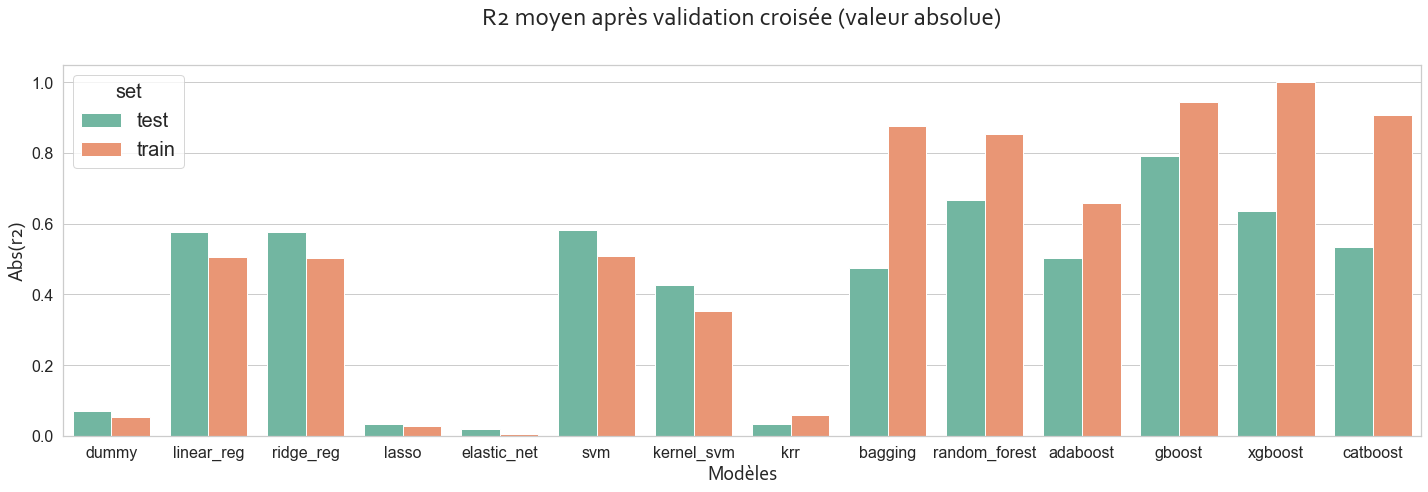

In [142]:
scores_copy = scores_energy.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()
titles = {"title": 'R2 moyen après validation croisée (valeur absolue)', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != 'mlp'],
                        'model', 'Abs(r2)', titles, (20, 7), 'set', True, 'Set2')

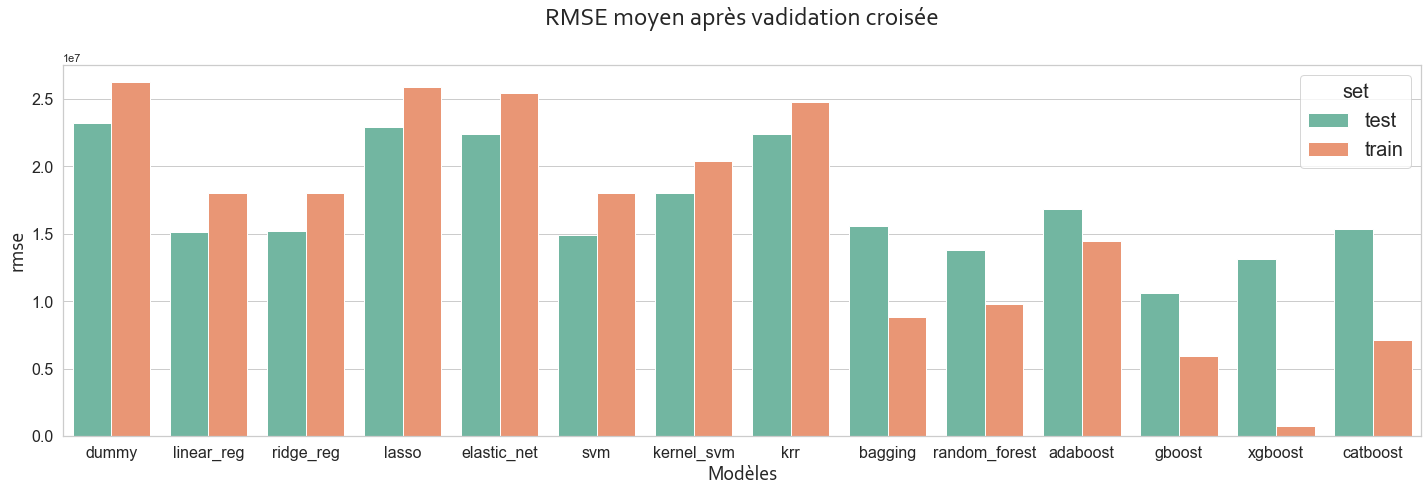

In [143]:
titles = {'title': 'RMSE moyen après vadidation croisée', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != 'mlp'],
                        'model', 'rmse', titles, (20, 7), 'set', True, 'Set2')

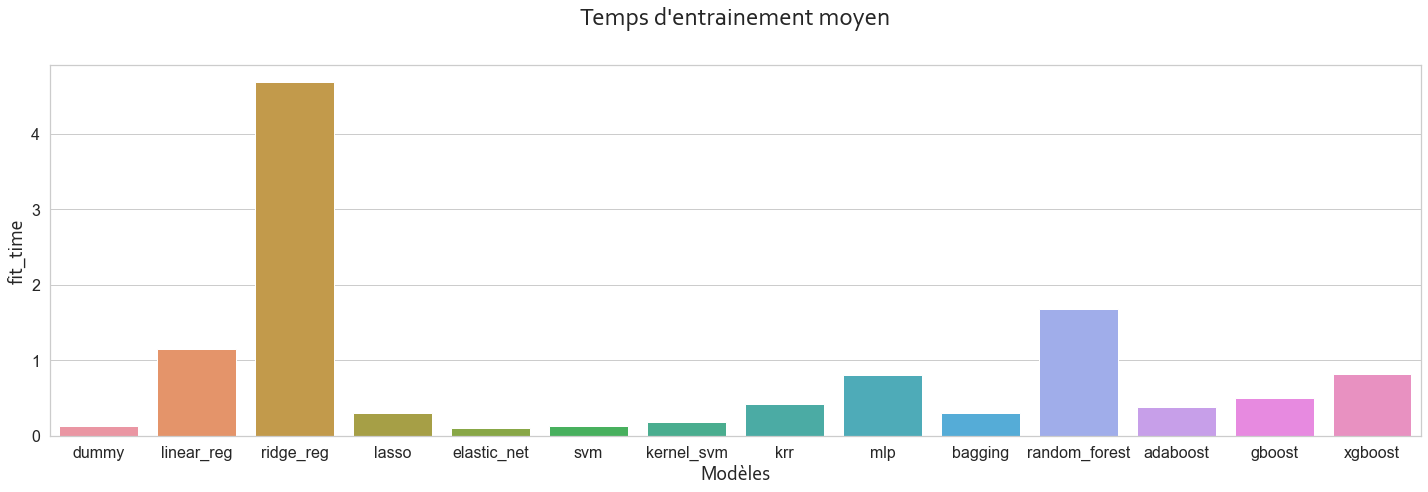

In [144]:
titles = {'title': 'Temps d\'entrainement moyen', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != 'catboost'], 'model', 'fit_time', titles, (20, 7))

<h3 style="font-family:Corbel Light; color:#737373">Analyse importance des variables</h3>

In [145]:
transformers = [{'feature': ['EnergyMixRatio', 'WorstEfficiencyGFA', 'BestEfficiencyGFA',
                             'MidOfficeEfficiencyGFA', 'LowEfficiencyGFA', 'MidOtherEfficiencyGFA', 'HighEfficiencyGFA'],
                 'estimator': [FunctionTransformer(np.log1p, feature_names_out='one-to-one'), RobustScaler()]},
                {'feature': ['AgeBuilding'],
                 'estimator': [RobustScaler()]},
                {'feature': ['LargestPropertyUseType', 'Neighborhood'],
                 'estimator': [TargetEncoder(smoothing=5, min_samples_leaf=2), RobustScaler()]},
                {'feature': ['PropertySize'],
                 'estimator': [OrdinalEncoder(categories=[["SmallMidSize", "Large"]], dtype=int)]}
                ]

preprocessor = toolbox.make_preprocessor(transformers)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<h4 style="font-family:Corbel Light; color:#737373">Régression linéaire (coefficients)</h4>

On regarde les coefficients du modèle pour en déduire l'importance des variables.

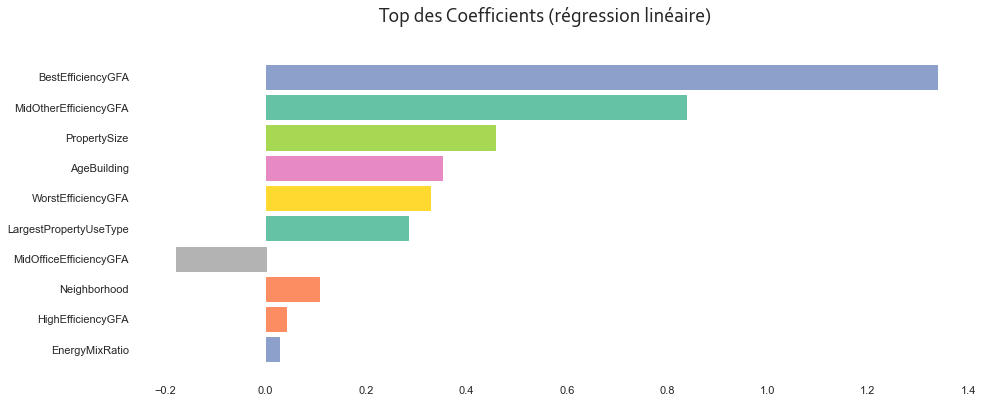

In [147]:
lr = toolbox.build_model(LinearRegression(), transformers)
lr.fit(X_train, y_train)

toolbox.plot_top_features_linear_model(lr.regressor_, X_train, "(régression linéaire)", (15, 6))

<h4 style="font-family:Corbel Light; color:#737373">Modèles ensemblistes(gradient boost, xgboost, forêt aléatoire)</h4>

<Figure size 1656x720 with 0 Axes>

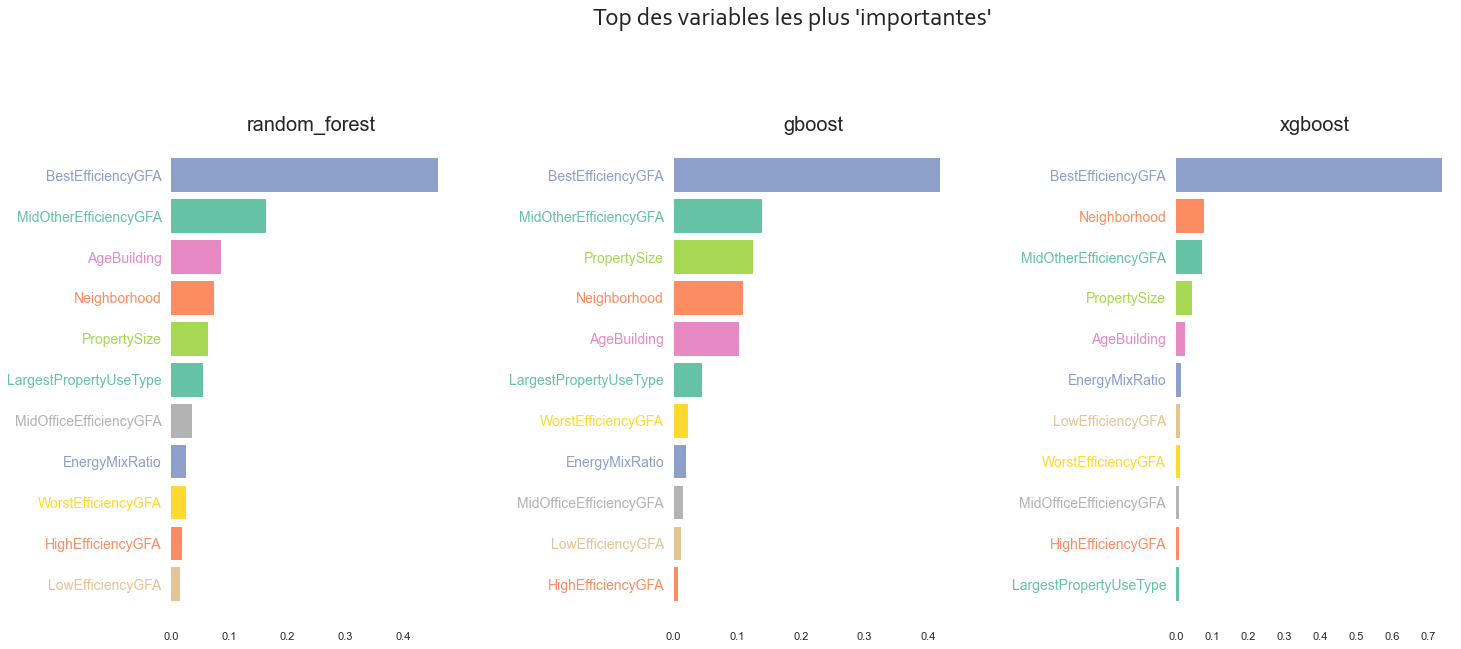

In [148]:
tree_models = []

regressors = [{'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8)},
              {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8)},
              {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8)}]

for model in regressors:
    reg = toolbox.build_model(model['regressor'], transformers)
    reg.fit(X_train, y_train)

    tree_models.append({"name": model['name'], "model": reg.regressor_[1]})

toolbox.plot_feature_importance_tree_model(tree_models, X_train.columns, (23, 10), 20)

<h4 style="font-family:Corbel Light; color:#737373">SHAP (gradient boost)</h4>

In [59]:
gb = toolbox.build_model(GradientBoostingRegressor(random_state=8), transformers)
gb.fit(X_train, y_train)

explainer = shap.TreeExplainer(gb.regressor_[1])

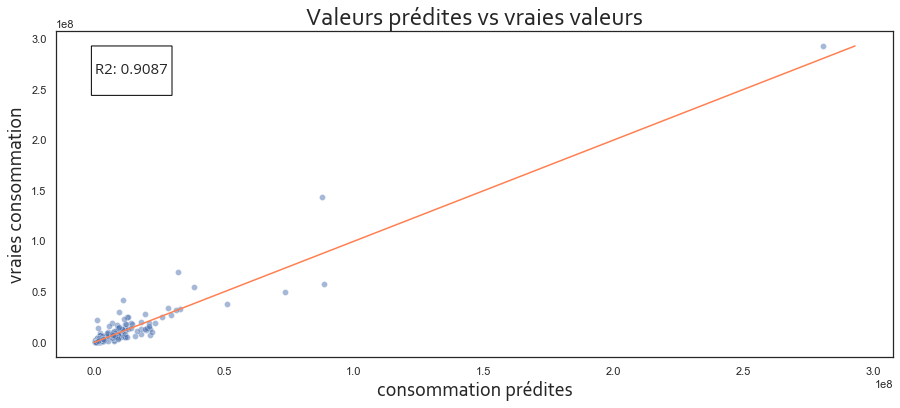

In [60]:
toolbox.plot_test_vs_pred(gb, y_test, X_test, 'SiteEnergyUse(kBtu)', 'consommation', 30_000_000)

In [61]:
y_pred = gb.predict(X_test)
error_df = X_test.copy()
error_df.insert(0, 'y_test', y_test)
error_df.insert(0, 'y_pred', y_pred)
error_df.insert(0, 'residuals', y_pred-y_test)
error_df.insert(0, 'logresidual', np.log1p(y_pred) - np.log1p(y_test))
error_df = error_df.reset_index()

Regardons pour quel type de bâtiment la consommation d'énergie est la moins bien prédite

In [62]:
error_bytype = pd.DataFrame(error_df.groupby('LargestPropertyUseType')[
                            'residuals'].median()).reset_index()
error_bytype['rmsle'] = error_bytype.apply(lambda row: mean_squared_log_error(error_df.loc[error_df['LargestPropertyUseType'] == row['LargestPropertyUseType']]['y_test'],
                                                                              error_df.loc[error_df['LargestPropertyUseType'] == row['LargestPropertyUseType']]['y_pred'],
                                                                              squared=False), axis=1)
error_bytype.sort_values('rmsle', ascending=False)

,LargestPropertyUseType,residuals,rmsle
1,Data Center,-30_385_284.97519,1.30565
2,Distribution Center,-737_142.59081,1.22517
7,Non-Refrigerated Warehouse,22_017.76474,0.75640
12,Retail Store,-375_193.46704,0.63746
10,Refrigerated Warehouse,-1_003_966.95186,0.62660
13,Senior Care Community,-2_693_032.68682,0.53703
8,Office,283_811.32516,0.53533
4,Hotel,144_566.84928,0.51885
16,Worship Facility,19_768.51864,0.49589
11,Residence Hall/Dormitory,240_674.89650,0.48062


Regardons de plus près pourquoi les consommations des centres de distributions sont mal prédites

In [63]:
error_df.loc[error_df['LargestPropertyUseType'] == 'Distribution Center'].sort_values('residuals', key=abs, ascending=False).head()

,index,logresidual,residuals,y_pred,y_test,LargestPropertyUseType,Neighborhood,EnergyMixRatio,AgeBuilding,PropertySize,WorstEfficiencyGFA,LowEfficiencyGFA,MidOfficeEfficiencyGFA,MidOtherEfficiencyGFA,HighEfficiencyGFA,BestEfficiencyGFA
100,249,-3.09201,-20_806_069.57492,989_760.42508,21_795_830.00000,Distribution Center,GREATER DUWAMISH,0.00076,67,Large,0.00000,0.00000,0.00000,0.00000,101_101.00000,0.00000
158,248,-1.50145,-7_272_368.14572,2_084_861.85428,9_357_230.00000,Distribution Center,GREATER DUWAMISH,0.47777,48,Large,0.00000,0.00000,0.00000,0.00000,162_425.00000,0.00000
252,931,-1.49978,-3_290_917.90162,945_478.59838,4_236_396.50000,Distribution Center,GREATER DUWAMISH,0.24467,45,SmallMidSize,0.00000,0.00000,0.00000,0.00000,28_320.00000,0.00000
233,295,-1.69902,-2_197_016.61514,491_659.13486,2_688_675.75000,Distribution Center,GREATER DUWAMISH,0.00000,106,SmallMidSize,0.00000,6_000.00000,10_500.00000,0.00000,51_040.00000,0.00000
148,392,-0.70755,-1_401_558.95979,1_362_038.04021,2_763_597.00000,Distribution Center,GREATER DUWAMISH,1.22729,37,SmallMidSize,0.00000,0.00000,0.00000,0.00000,55_000.00000,0.00000


La librairie shap permet notamment de visualiser l'impact de chaque variable sur la prédiction de notre choix.

In [64]:
sample_idx = 233

shap_vals = explainer.shap_values(gb.regressor_[0].transform(X_test.iloc[sample_idx:sample_idx+1]))[0]

print("Expected/Base Value : ", explainer.expected_value)
print("\nShap Values for Sample %d : " % sample_idx, shap_vals)

print("\nPrediction From Model                            : ",
      gb.predict(X_test.iloc[sample_idx:sample_idx+1])[0])
print("Prediction From Adding SHAP Values to Base Value : ",
      np.exp(explainer.expected_value + shap_vals.sum()))

Expected/Base Value :  [14.99780481]

Shap Values for Sample 233 :  [-0.44176993 -0.07671462 -0.04160159 -0.32450112 -0.22841577 -0.05569019
  0.10991458 -0.04575094 -0.5037864   0.00609362 -0.29004152]

Prediction From Model                            :  491659.1348580475
Prediction From Adding SHAP Values to Base Value :  [491659.13485805]


Par exemple, pour cette prédiction il semblerait que la surface à faible efficience energétique fasse augmenter la valeur prédite en consommation alors que les autres variables font plutôt baisser cette valeur (les 2 représentations graphiques ci-dessous illustrent la même chose de deux manières différentes)

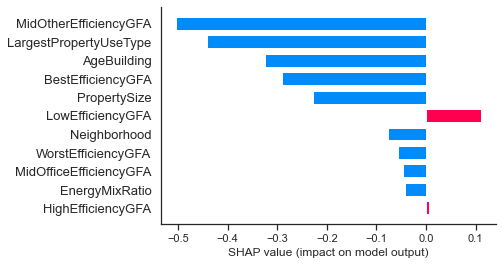

In [65]:
shap.bar_plot(shap_vals, feature_names=X_train.columns, max_display=20)

In [66]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(gb.regressor_[0].transform(X_test.iloc[sample_idx:sample_idx+1])),
                feature_names=X_train.columns,
                out_names="SiteEnergyUse(kBtu)")

Shap permet également de visualiser l'impact de chaque variable sur l'ensemble des prédictions. Dans le graphique ci-dessous, chaque point correspond à une observation. Un point rouge indique une valeur élevée de la variable pour cette observation, un point bleu une valeur faible. 

On voit que des valeurs élevées pour  l'age du bâtiment (AgeBuilding) font augmenter la valeur prédite d'énergie consommée.

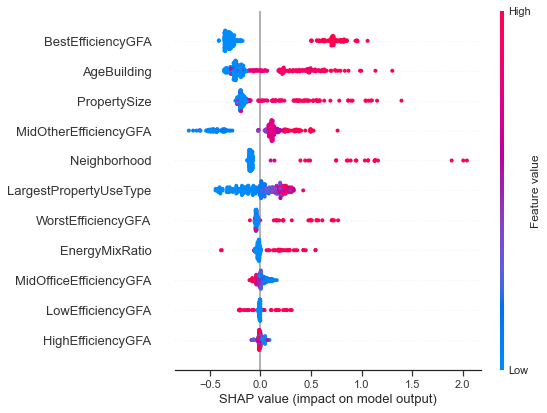

In [67]:
shap.summary_plot(explainer.shap_values(gb.regressor_[0].transform(X_test)),
                  features=gb.regressor_[0].transform(X_test),
                  feature_names=X_train.columns)

<h3 style="font-family:Corbel Light; color:#737373">Optimisation</h3>

On va optimiser le Gradient Boosting, XGBoosting et la forêt aléatoire

spoiler : après optimisation, on retient plutôt le modèle XGBoost (dont l'optimisation a permis de bien limiter le surapprentissage et de stabiliser le R2). La forêt aléatoire est trop lente comparée aux 2 modèles de boosting.

In [149]:
transformers = [{'feature': ['EnergyMixRatio', 'WorstEfficiencyGFA', 'BestEfficiencyGFA',
                             'MidOfficeEfficiencyGFA', 'LowEfficiencyGFA', 'MidOtherEfficiencyGFA', 'HighEfficiencyGFA'],
                 'estimator': [FunctionTransformer(np.log1p, feature_names_out='one-to-one'), RobustScaler()]},
                {'feature': ['AgeBuilding'],
                 'estimator': [RobustScaler()]},
                {'feature': ['LargestPropertyUseType', 'Neighborhood'],
                 'estimator': [TargetEncoder(smoothing=5, min_samples_leaf=2), RobustScaler()]},
                {'feature': ['PropertySize'],
                 'estimator': [OrdinalEncoder(categories=[["SmallMidSize", "Large"]], dtype=int)]}
                ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

datasets = {'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test}

<h4 style="font-family:Corbel Light; color:#737373">Gradient Boosting</h4>

In [150]:
# fonction à minimiser
def gb_r2_cv(params, X: np.array, y: np.array, transformers: dict, random_state=8, cv=5):
    reg = GradientBoostingRegressor(random_state=random_state, **params)
    model = toolbox.build_model(reg, transformers)

    score = -cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    return score


space_gb = {'n_estimators': scope.int(hp.quniform('n_estimators', 700, 1200, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
            'max_features': scope.int(hp.quniform('max_features', ceil(np.sqrt(X.shape[1])), X.shape[1], 1)),
            # 'n_iter_no_change' : scope.int(hp.quniform('n_iter_no_change', 5, 100, 1)),
            'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 2, 10, 1)),
            'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 15, 1))
            }

print("-R2 sans optimisation : {:.4f}\n".format(gb_r2_cv({}, X_train, y_train, transformers)))

trials_gb = Trials()
best_params_gb = fmin(fn=partial(gb_r2_cv, X=X_train, y=y_train, transformers=transformers),
                      space=space_gb,
                      algo=tpe.suggest,
                      max_evals=100,
                      trials=trials_gb,
                      rstate=np.random.default_rng(8),
                      early_stop_fn=no_progress_loss(20)
                      )

-R2 sans optimisation : -0.6223

 22%|██▏       | 22/100 [02:17<08:06,  6.23s/trial, best loss: -0.6619366904952205]


Regardons la valeur du R2 pour chaque combinaison de paramètres testée par hyperopt

In [70]:
trials_df_gb = toolbox.build_trial_df(trials_gb, '-r2')
trials_df_gb.head()

,learning_rate,max_depth,max_features,n_estimators,n_iter_no_change,-r2,trial_number
0,0.69765,5.00000,11.00000,784.00000,55.00000,-0.44381,0
1,0.33133,5.00000,5.00000,996.00000,32.00000,-0.33041,1
2,0.29387,4.00000,6.00000,1_171.00000,67.00000,-0.49596,2
3,0.18432,4.00000,11.00000,879.00000,75.00000,-0.54960,3
4,0.29740,4.00000,8.00000,1_047.00000,34.00000,-0.46607,4


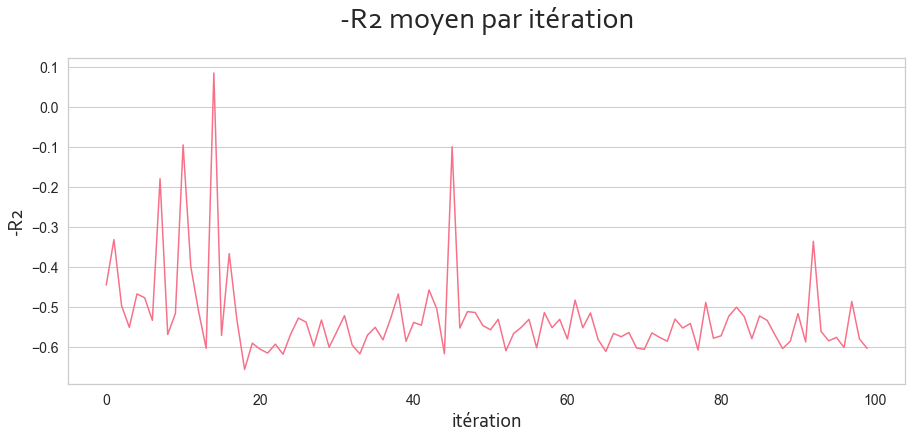

In [71]:
titles = {'title': '-R2 moyen par itération',
          'xlabel': 'itération', 
          'ylabel': '-R2'}

toolbox.display_lineplot(trials_df_gb, 'trial_number',
                         '-r2', (15, 6), titles, grid_x=False)

Regardons quels sont les meilleurs paramètres et le score du modèle optimisé sur le jeu de test

In [160]:
best_model_gb = GradientBoostingRegressor(random_state=8, n_iter_no_change=5,
                                          n_estimators=int(best_params_gb['n_estimators']),
                                          max_depth=int(best_params_gb['max_depth']),
                                          learning_rate=best_params_gb['learning_rate'],
                                          max_features=int(best_params_gb['max_features']),
                                          # n_iter_no_change=int(best_params_gb['n_iter_no_change']),
                                          min_samples_leaf=int(best_params_gb['min_samples_leaf']),
                                          min_samples_split=int(best_params_gb['min_samples_split'])
                                          )

best_model_gb_fit = toolbox.score_best_model(best_model_gb, transformers, best_params_gb, datasets)

,Param,Best Param
0,learning_rate,0.55946
1,max_depth,4.00000
2,max_features,11.00000
3,min_samples_leaf,3.00000
4,min_samples_split,10.00000
5,n_estimators,844.00000


Modèle optimisé : 
Test R2 : 0.8877
Temps d'entrainement : 0.131
Train R2 : 0.8964

Ecart type R2 (validation croisée sur train set) : 0.1863


On a réussi à limiter le surapprentissage du modèle, mais le score du R2 est toujours aussi instable, ce qui rend difficile le fine tunning

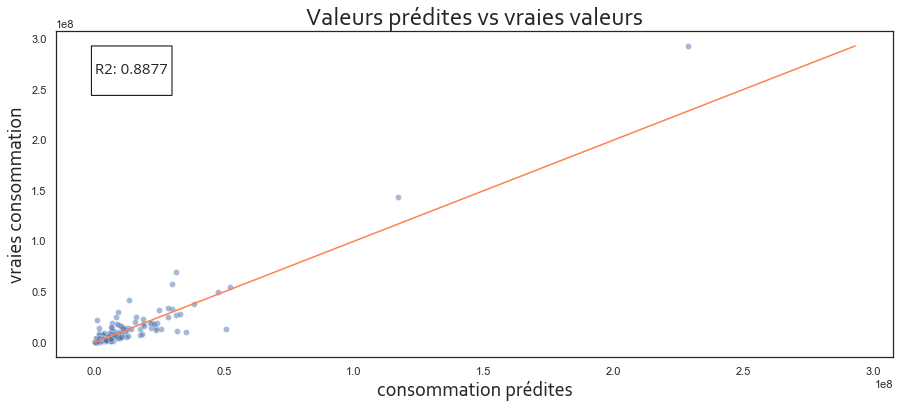

In [162]:
toolbox.plot_test_vs_pred(best_model_gb_fit, y_test, X_test,
                          'SiteEnergyUse(kBtu)', 'consommation', 30_000_000)

La courbe d'apprentissage montre l'évolution du R2 en fonction du nombre d'observations dans le jeu d'entrainement.

In [163]:
X_train.shape

(692, 11)

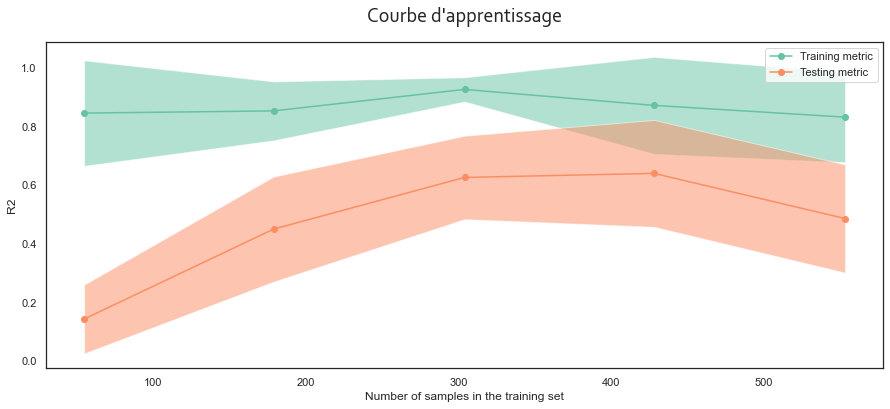

In [164]:
toolbox.display_learning_curve(best_model_gb, X_train, y_train, transformers, (15, 6))

<h4 style="font-family:Corbel Light; color:#737373">XGBoost</h4>

In [206]:
#fonction à minimiser
def xgb_r2_cv(params, X: np.array, y: np.array, transformers: dict, random_state=8, cv=5):
    reg = xgb.XGBRegressor(seed=random_state, **params)
    model = toolbox.build_model(reg, transformers)

    score = -cross_val_score(model, X, y, cv=cv,
                             scoring="r2", n_jobs=-1).mean()

    return score


space_xgb = {'eta': hp.loguniform('eta', np.log(0.1), np.log(0.7)),
             'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
             'gamma': hp.uniform('gamma', 0, 100),
             # 'reg_lambda' : hp.uniform('reg_lambda', 0, 100),
             'n_estimators': scope.int(hp.quniform('n_estimators', 500, 1200, 1)),
             'subsample': hp.uniform('subsample', 0.7, 1)
             }

trials_xgb = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(xgb_r2_cv({}, X_train, y_train, transformers)))

best_params_xgb = fmin(fn=partial(xgb_r2_cv, X=X_train, y=y_train, transformers=transformers),
                       space=space_xgb,
                       algo=tpe.suggest,
                       max_evals=150,
                       trials=trials_xgb,
                       rstate=np.random.default_rng(8),
                       # early_stop_fn=no_progress_loss(30)
                       )

-R2 sans optimisation : -0.6366

100%|██████████| 150/150 [04:59<00:00,  2.00s/trial, best loss: -0.6942049295156598]


Regardons la valeur du R2 pour chaque combinaison de paramètres testée par hyperopt

In [166]:
trials_df_xgb = toolbox.build_trial_df(trials_xgb, '-r2')
trials_df_xgb.head()

,colsample_bytree,eta,gamma,max_depth,n_estimators,subsample,-r2,trial_number
0,0.68544,0.69765,85.69967,5.00000,667.00000,0.85819,-0.08098,0
1,0.94241,0.33133,97.74519,3.00000,837.00000,0.78656,-0.06822,1
2,0.92548,0.29387,64.93846,3.00000,976.00000,0.89480,-0.10426,2
3,0.85233,0.18432,62.18732,5.00000,743.00000,0.91973,-0.10595,3
4,0.88423,0.29740,60.48245,4.00000,878.00000,0.79222,-0.10935,4


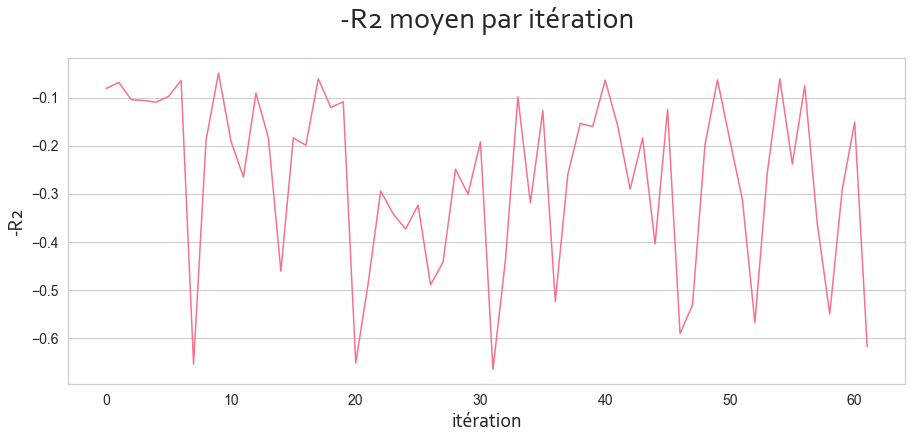

In [167]:
titles = {'title': '-R2 moyen par itération',
          'xlabel': 'itération', 'ylabel': '-R2'}
toolbox.display_lineplot(trials_df_xgb, 'trial_number',
                         '-r2', (15, 6), titles, grid_x=False)

Regardons quels sont les meilleurs paramètres et le score du modèle optimisé sur le jeu de test

In [210]:
best_model_xgb = xgb.XGBRegressor(seed=8,
                                  max_depth=int(best_params_xgb['max_depth']),
                                  eta=best_params_xgb['eta'],
                                  colsample_bytree=best_params_xgb['colsample_bytree'],
                                  gamma=best_params_xgb['gamma'],
                                  # reg_lambda=best_params_xgb['reg_lambda'],
                                  n_estimators=int(best_params_xgb['n_estimators']),
                                  subsample=best_params_xgb['subsample'],
                                  )

best_model_xgb_fit = toolbox.score_best_model(best_model_xgb, transformers, best_params_xgb, datasets)

,Param,Best Param
0,colsample_bytree,0.67826
1,eta,0.41188
2,gamma,0.37955
3,max_depth,2.00000
4,n_estimators,1_125.00000
5,subsample,0.97084


Modèle optimisé : 
Test R2 : 0.8809
Temps d'entrainement : 0.820
Train R2 : 0.9544

Ecart type R2 (validation croisée sur train set) : 0.0971


Le XGBoost surapprend un peu plus que le GBoost après optimisation. Mais on a réussi à grandement réduire l'écart type du R2, pour obtenir un résultat plus stable.

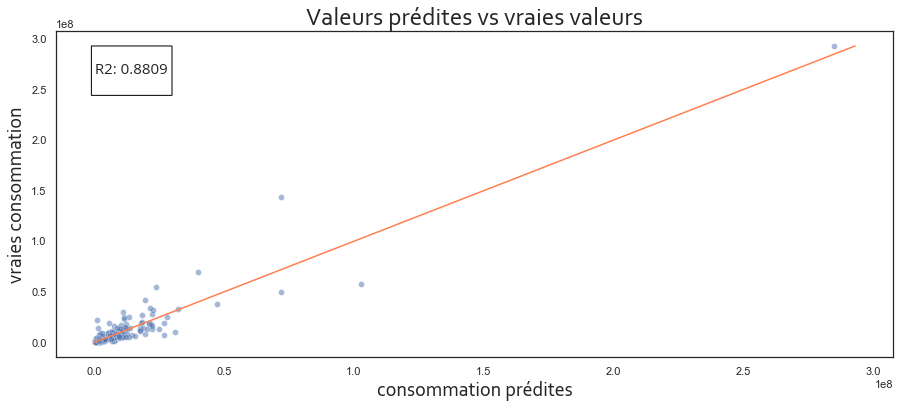

In [211]:
toolbox.plot_test_vs_pred(best_model_xgb_fit, y_test, X_test,
                          'SiteEnergyUse(kBtu)', 'consommation', 30_000_000)

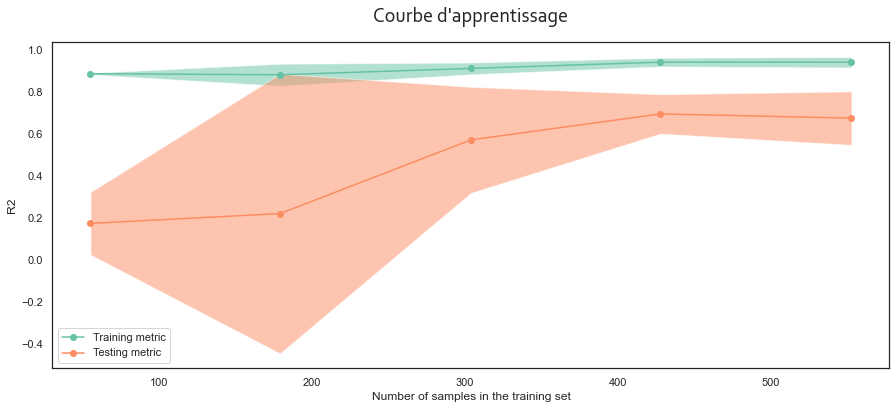

In [212]:
toolbox.display_learning_curve(best_model_xgb, X_train, y_train, transformers, (15, 6))

<h4 style="font-family:Corbel Light; color:#737373">Forêt Aléatoire</h4>

In [225]:
# fonction à minimiser
def rndforest_r2_cv(params, random_state=8, cv=5, X=X_train, y=y_train, transformers=transformers):
    reg = RandomForestRegressor(random_state=8, **params)
    model = toolbox.build_model(reg, transformers)

    score = -cross_val_score(model, X, y, cv=cv,
                             scoring="r2", n_jobs=-1).mean()

    return score


space_rf = {'n_estimators': scope.int(hp.quniform('n_estimators', 900, 1300, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 15, 1)),
            'max_features': scope.int(hp.quniform('max_features', ceil(np.sqrt(X.shape[1])), X.shape[1], 1)),
            # 'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
            # 'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 10, 1))
            }

trials_rf = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(rndforest_r2_cv({})))

best_params_rf = fmin(fn=rndforest_r2_cv,
                      space=space_rf,
                      algo=tpe.suggest,
                      max_evals=50,
                      trials=trials_rf,
                      rstate=np.random.default_rng(8),
                      early_stop_fn=no_progress_loss(15)
                      )

-R2 sans optimisation : -0.5919

 98%|█████████▊| 49/50 [12:35<00:15, 15.42s/trial, best loss: -0.6043919823253457]


Regardons la valeur du R2 pour chaque combinaison de paramètres testée par hyperopt

In [226]:
trials_df_rf = toolbox.build_trial_df(trials_rf, '-r2')
trials_df_rf.head()

,max_depth,max_features,n_estimators,-r2,trial_number
0,14.00000,5.00000,1_111.00000,-0.54822,0
1,4.00000,8.00000,1_015.00000,-0.48972,1
2,6.00000,11.00000,1_160.00000,-0.59363,2
3,15.00000,7.00000,1_193.00000,-0.57806,3
4,10.00000,9.00000,1_023.00000,-0.59184,4


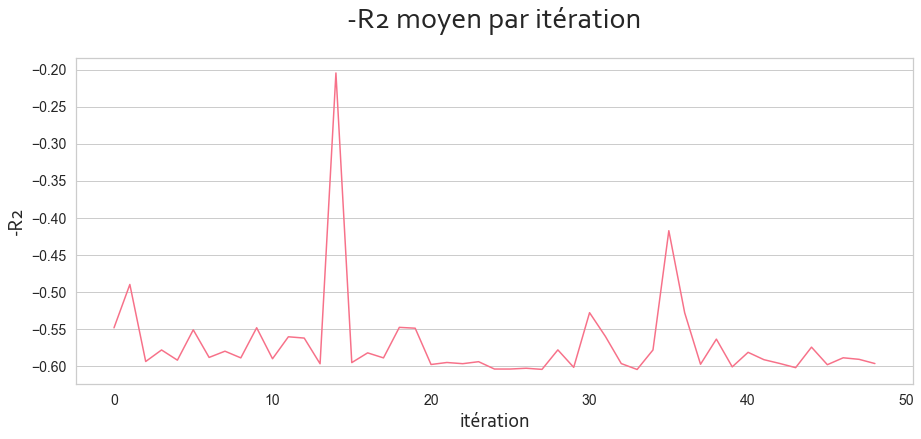

In [227]:
titles = {'title': '-R2 moyen par itération',
          'xlabel': 'itération',
          'ylabel': '-R2'}

toolbox.display_lineplot(trials_df_rf, 'trial_number',
                         '-r2', (15, 6), titles, grid_x=False)

Regardons quels sont les meilleurs paramètres et le score du modèle optimisé sur le jeu de test

In [228]:
best_rndforest = RandomForestRegressor(random_state=8,
                                       n_estimators=int(best_params_rf['n_estimators']),
                                       max_depth=int(best_params_rf['max_depth']),
                                       max_features=int(best_params_rf['max_features']),
                                       # min_samples_leaf=int(best_params_rf['min_samples_leaf']),
                                       # min_samples_split=int(best_params_rf['min_samples_split'])
                                       )

best_rndforest_fit = toolbox.score_best_model(best_rndforest, transformers, best_params_rf, datasets)

,Param,Best Param
0,max_depth,13.00000
1,max_features,11.00000
2,n_estimators,1_067.00000


Modèle optimisé : 
Test R2 : 0.8076
Temps d'entrainement : 9.704
Train R2 : 0.8232

Ecart type R2 (validation croisée sur train set) : 0.2269


Ce modèle est beaucoup plus lent à entrainer que les 2 modèles de boosting mais surapprend moins.

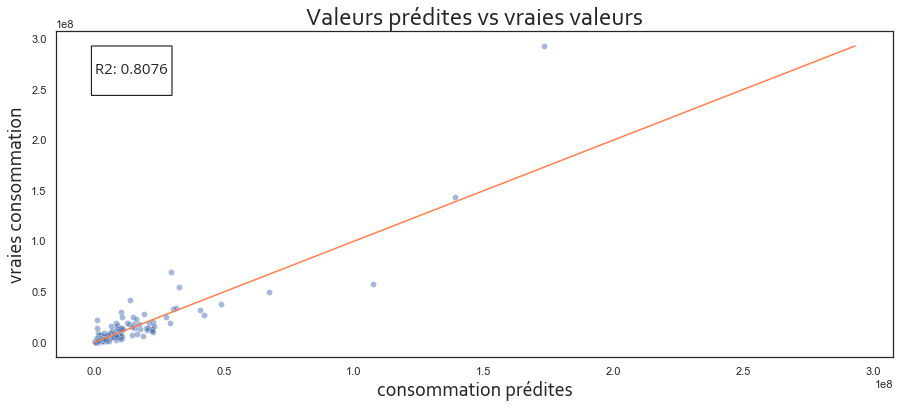

In [229]:
toolbox.plot_test_vs_pred(best_rndforest_fit, y_test, X_test,
                          'SiteEnergyUse(kBtu)', 'consommation', 30_000_000)

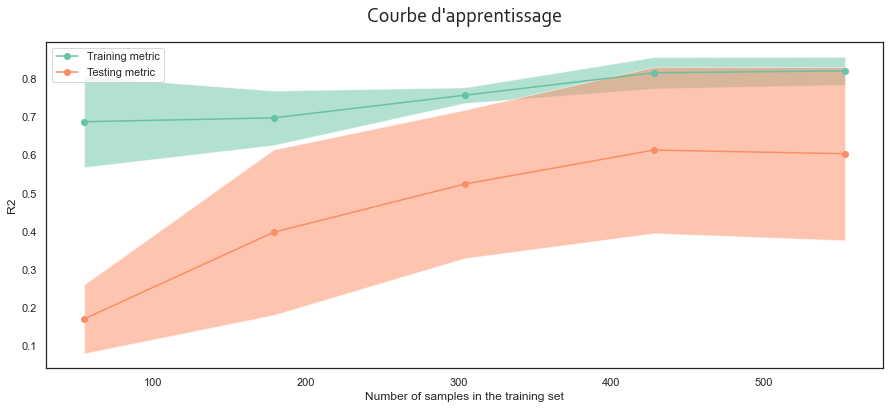

In [230]:
toolbox.display_learning_curve(best_rndforest, X_train, y_train, transformers, (15, 6))

<h3 style="font-family:Corbel Light; color:#737373">Modèles avec Energy Star Score</h3>

In [231]:
X_star = data_building_new.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

In [232]:
transformers_star = [{'feature': ['EnergyMixRatio', 'WorstEfficiencyGFA', 'LowEfficiencyGFA', 'MidOfficeEfficiencyGFA',
                                  'MidOtherEfficiencyGFA', 'HighEfficiencyGFA', 'BestEfficiencyGFA'],
                      'estimator': [FunctionTransformer(np.log1p, feature_names_out='one-to-one'), RobustScaler()]},
                     {'feature': ['AgeBuilding'],
                      'estimator': [RobustScaler()]},
                     {'feature': ['Neighborhood', 'LargestPropertyUseType'],
                      'estimator': [TargetEncoder(smoothing=5, min_samples_leaf=2), RobustScaler()]},
                     {'feature': ['PropertySize'], 
                      'estimator': [OrdinalEncoder(categories=[["SmallMidSize", "Large"]], dtype=int)]},
                     {'feature': ['ENERGYSTARScore'],
                      'estimator': [FunctionTransformer(np.square), RobustScaler()]}
                     ]

feature_categ = ['Neighborhood', 'LargestPropertyUseType', 'PropertySize']

regressors = [
    {'name': 'dummy', 'regressor': DummyRegressor(strategy='median'), 'with_pipeline': True},
    {'name': 'linear_reg', 'regressor': LinearRegression(), 'with_pipeline': True},
    {'name': 'ridge_reg', 'regressor': Ridge(), 'with_pipeline': True},
    {'name': 'lasso', 'regressor': Lasso(), 'with_pipeline': True},
    {'name': 'elastic_net', 'regressor': ElasticNet(), 'with_pipeline': True},
    {'name': 'svm', 'regressor': LinearSVR(), 'with_pipeline': True},
    {'name': 'kernel_svm', 'regressor': SVR(kernel='rbf'), 'with_pipeline': True},
    {'name': 'krr', 'regressor': KernelRidge(kernel='rbf'), 'with_pipeline': True},
    {'name': 'mlp', 
     'regressor': MLPRegressor(hidden_layer_sizes=(X_star.shape[1], 1), random_state=8, activation='identity'), 
     'with_pipeline': True},
    {'name': 'bagging', 'regressor': BaggingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'adaboost', 'regressor': AdaBoostRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8), 'with_pipeline': True},
    {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8), 'with_pipeline': True},
    {'name': 'catboost', 
     'regressor': ctb.CatBoostRegressor(cat_features=feature_categ, random_seed=8), 'with_pipeline': False}
]

scores_energy_star = toolbox.cross_validate_and_score(regressors, X_star, y, transformers_star, 5)

In [233]:
scores_energy_star.insert(0, 'energy_star_score', 'avec')
scores_energy.insert(0, 'energy_star_score', 'sans')
scores_energy_all = pd.concat([scores_energy, scores_energy_star], ignore_index=True)

In [234]:
scores_test_all = scores_energy_all.loc[scores_energy_all['set'] == 'test']
scores_test_all.sort_values(['r2', "rmsle", 'fit_time'], ascending=[False, True, True]).head(10)

,energy_star_score,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
54,avec,gboost,test,0.22371,9_738_908.61437,0.38567,0.79501,142_846_118_448_093.81250,3_178_058.88283,0.56241,0.03441,6_928_187.16902,0.03488,0.13520,167_521_250_709_378.31250,2_563_632.85496
24,sans,gboost,test,0.36587,10_576_760.72571,0.52941,0.79123,219_654_816_745_175.62500,3_655_977.79238,0.50481,0.04895,10_382_049.37843,0.05824,0.17343,338_791_007_666_638.56250,3_166_715.81632
56,avec,xgboost,test,0.22896,13_079_914.64850,0.39411,0.68512,293_629_982_828_501.81250,3_603_734.13742,0.74560,0.01231,11_070_041.35569,0.04921,0.23645,406_200_268_578_669.75000,3_038_225.18683
20,sans,random_forest,test,0.33888,13_806_176.00803,0.49207,0.66630,316_342_460_190_021.06250,3_901_343.18576,1.68299,0.02788,11_213_026.54172,0.05299,0.22170,435_999_099_194_253.68750,3_101_801.38031
50,avec,random_forest,test,0.23609,14_017_460.94745,0.36599,0.66037,319_947_419_551_252.87500,3_586_145.29865,1.85366,0.03630,11_111_174.92158,0.04686,0.21052,433_493_284_085_321.81250,3_017_693.37469
26,sans,xgboost,test,0.40097,13_130_222.48039,0.56312,0.63596,292_423_079_870_358.75000,4_034_641.71782,0.81566,0.04637,10_955_379.38576,0.06274,0.22485,431_968_708_072_561.25000,3_154_806.84298
58,avec,catboost,test,0.19375,14_477_800.01995,0.31594,0.59938,383_505_492_770_582.37500,3_377_719.69204,60.26133,0.04074,13_187_069.39971,0.03713,0.31147,556_168_525_288_983.50000,3_193_288.97545
10,sans,svm,test,0.60891,14_908_000.13330,0.70881,0.58280,349_069_881_247_975.37500,5_069_058.96883,0.13860,0.12211,11_261_501.37741,0.10941,0.22779,467_729_984_802_901.81250,4_120_726.74496
40,avec,svm,test,0.49199,14_474_359.94185,0.60912,0.58188,323_389_112_495_801.87500,4_954_246.52661,0.20019,0.13007,10_671_551.75078,0.06453,0.29055,393_780_309_794_991.93750,4_053_161.05325
32,avec,linear_reg,test,0.47316,14_581_809.14874,0.60506,0.57983,325_887_530_866_173.75000,4_881_900.82754,0.22570,0.11751,10_642_291.70883,0.06529,0.28392,397_261_382_525_694.00000,4_045_518.36577


In [235]:
scores_train_all = scores_energy_all.loc[scores_energy_all['set'] == 'train']
scores_train_all.sort_values(['rmse', 'r2', 'fit_time'], ascending=[True, False, True]).head(10)

,energy_star_score,model,set,rmsle,rmse,mape,r2,mse,mae,fit_time,rmsle_std,rmse_std,mape_std,r2_std,mse_std,mae_std
57,avec,xgboost,train,0.00130,298_962.63229,0.02495,0.99986,93_406_270_363.16281,133_623.57435,0.74560,0.00019,63_463.49234,0.00152,0.00003,35_147_841_973.44572,29_893.02694
27,sans,xgboost,train,0.00752,727_028.94204,0.06029,0.99919,561_578_894_673.23242,324_987.82984,0.81566,0.00125,181_680.52208,0.00517,0.00022,247_600_848_093.07248,77_432.71902
59,avec,catboost,train,0.03038,5_334_145.47646,0.13237,0.94906,29_188_910_398_867.17969,1_123_754.06762,60.26133,0.00255,857_789.27180,0.00582,0.02799,8_085_225_005_487.70020,150_673.70598
55,avec,gboost,train,0.08273,5_580_062.79031,0.22868,0.95111,31_569_839_981_853.44922,1_578_022.77254,0.56241,0.00184,657_829.18607,0.00302,0.00657,6_848_942_949_048.69727,236_857.86268
25,sans,gboost,train,0.17447,5_925_483.77231,0.33805,0.94504,35_863_940_207_446.54688,2_003_601.72949,0.50481,0.00457,867_514.99789,0.00424,0.00858,9_952_094_512_412.57812,351_287.87565
29,sans,catboost,train,0.09850,7_091_638.92828,0.24662,0.90669,52_085_233_718_876.93750,1_800_478.41092,55.25132,0.00701,1_339_362.17274,0.00884,0.06147,17_516_034_451_022.93555,293_454.24725
19,sans,bagging,train,0.06163,8_844_120.52501,0.17959,0.87633,84_772_143_369_624.25000,1_663_447.65046,0.29860,0.00093,2_560_014.74776,0.00277,0.04818,43_840_942_948_829.39844,337_977.41076
49,avec,bagging,train,0.04513,9_054_243.96922,0.14207,0.86992,86_502_714_470_609.89062,1_576_417.23043,0.31121,0.00249,2_126_824.06807,0.00238,0.03981,37_150_961_866_990.00781,267_845.96996
21,sans,random_forest,train,0.04660,9_771_334.29474,0.15952,0.85245,99_224_358_605_932.90625,1_655_599.97970,1.68299,0.00141,1_935_299.64251,0.00186,0.02781,35_672_211_843_998.75000,313_422.75450
51,avec,random_forest,train,0.03111,10_020_079.14174,0.12084,0.84325,102_884_562_944_318.34375,1_551_965.07642,1.85366,0.00086,1_575_619.54087,0.00127,0.02467,30_038_281_573_408.65234,272_033.68808


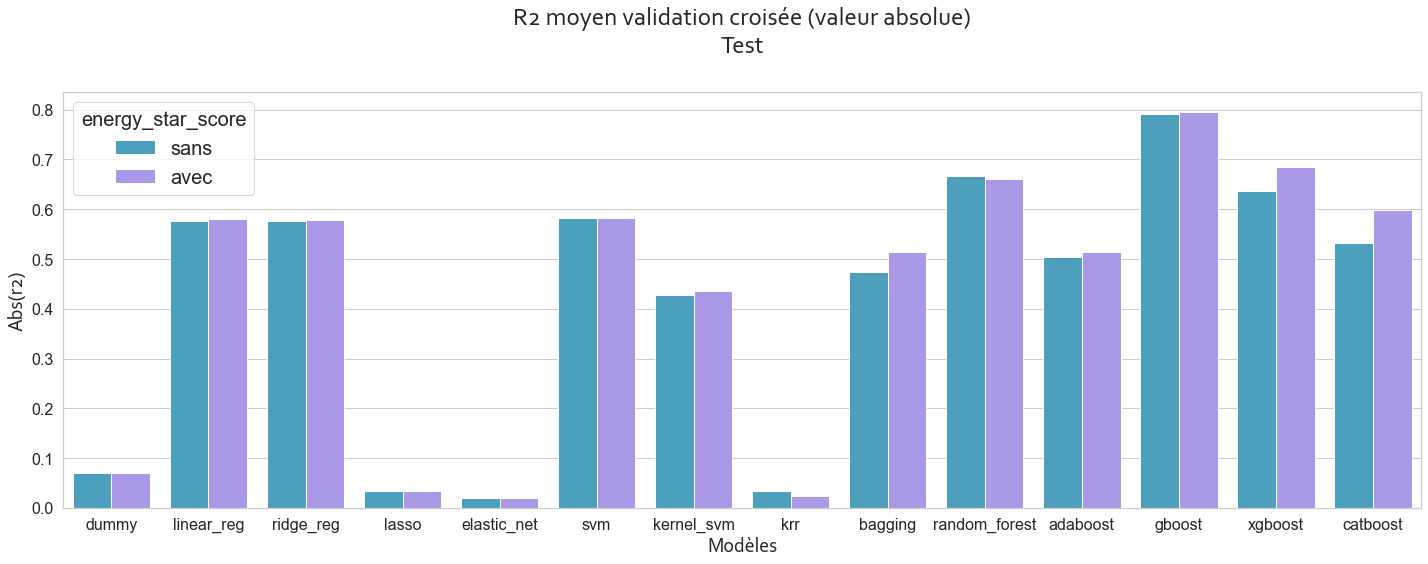

In [236]:
scores_copy = scores_test_all.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()

titles = {'title': 'R2 moyen validation croisée (valeur absolue)\nTest', 
          'xlabel': 'Modèles'}

palette = sns.color_palette("husl", 8)[5:7]
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != "mlp"],
                        'model', 'Abs(r2)', titles, (20, 8), 'energy_star_score', True, palette)

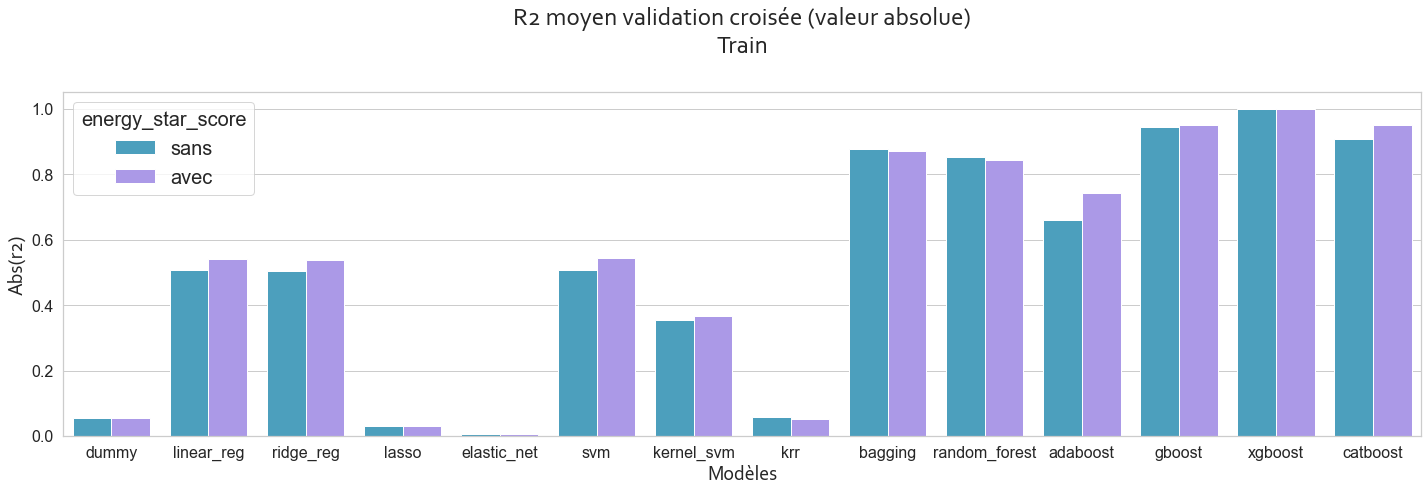

In [237]:
scores_copy = scores_train_all.copy()
scores_copy['Abs(r2)'] = scores_copy['r2'].abs()

titles = {'title': 'R2 moyen validation croisée (valeur absolue)\nTrain', 
          'xlabel': 'Modèles'}

palette = sns.color_palette("husl", 8)[5:7]
toolbox.display_barplot(scores_copy.loc[scores_copy['model'] != "mlp"],
                        'model', 'Abs(r2)', titles, (20, 7), 'energy_star_score', True, palette)

Il semblerait que l'ajout de l'energy star score n'améliore pas les résultats de manière significative.

<h4 style="font-family:Corbel Light; color:#737373">Analyse Importance des features</h4>

Regardons quelle importance les modèles gradient boost, xgboost et forêt aléatoire accordent à l'energy star score

<Figure size 1656x720 with 0 Axes>

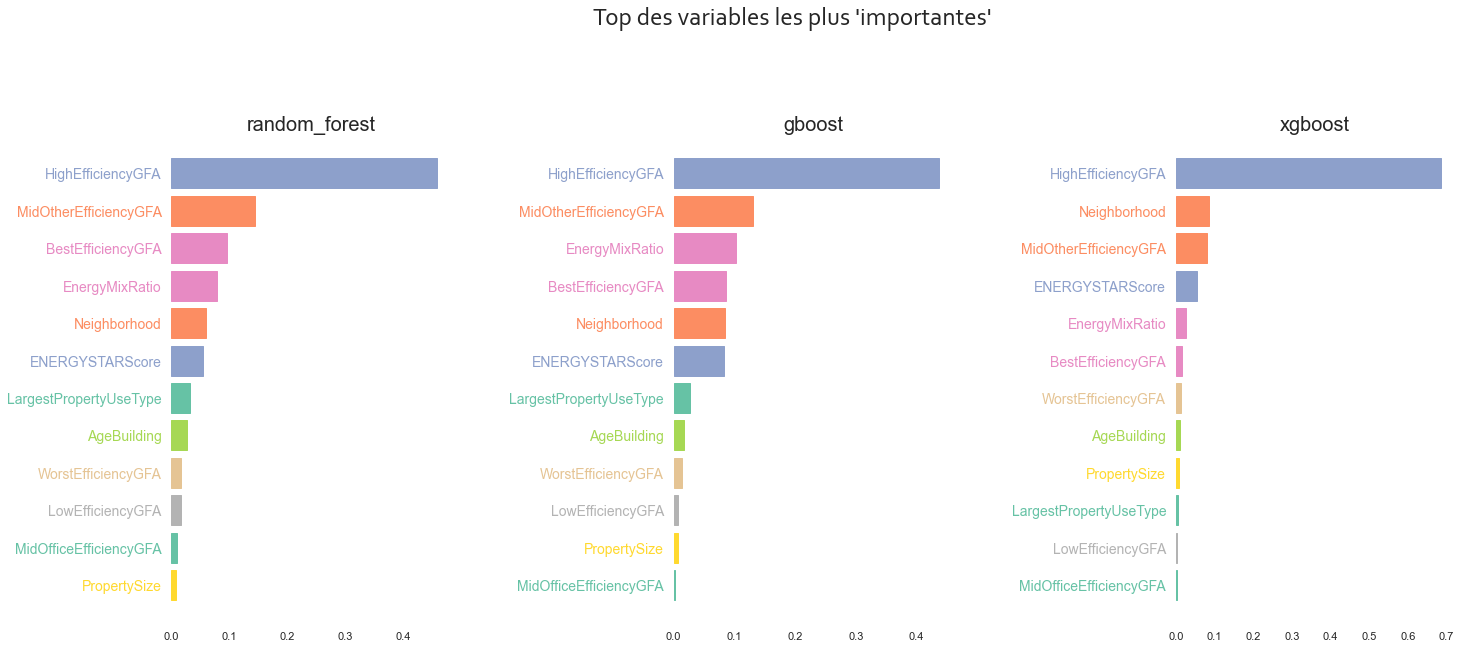

In [238]:
tree_models = []

regressors = [{'name': 'random_forest', 'regressor': RandomForestRegressor(random_state=8)},
              {'name': 'gboost', 'regressor': GradientBoostingRegressor(random_state=8)},
              {'name': 'xgboost', 'regressor': xgb.XGBRegressor(seed=8)}]

for model in regressors:
    reg = toolbox.build_model(model['regressor'], transformers_star)
    reg.fit(X_star, y)

    tree_models.append({"name": model['name'], "model": reg.regressor_[1]})

toolbox.plot_feature_importance_tree_model(tree_models, X_star.columns, (23, 10), 20)

<h4 style="font-family:Corbel Light; color:#737373">Optimisation</h4>

In [241]:
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y, test_size=0.3, random_state=10)
datasets_star = {'X_train': X_star_train, 'y_train': y_star_train,
                 'X_test': X_star_test, 'y_test': y_star_test}

<h5 style="font-family:Corbel Light; color:#737373">Gradient Boosting</h5>

In [242]:
space_gb = {'n_estimators': scope.int(hp.quniform('n_estimators', 700, 1200, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
            'max_features': scope.int(hp.quniform('max_features', ceil(np.sqrt(X.shape[1])), X.shape[1], 1)),
            'n_iter_no_change': scope.int(hp.quniform('n_iter_no_change', 5, 100, 1)),
            # 'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 2, 10, 1)),
            # 'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 15, 1))
            }

trials_gb_star = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(gb_r2_cv({},
      X_star_train, y_star_train, transformers_star)))

best_params_gb_star = fmin(fn=partial(gb_r2_cv, X=X_star_train, y=y_star_train, transformers=transformers_star),
                           space=space_gb,
                           algo=tpe.suggest,
                           max_evals=70,
                           trials=trials_gb_star,
                           rstate=np.random.default_rng(8),
                           # early_stop_fn=no_progress_loss(10)
                           )

-R2 sans optimisation : -0.6641

100%|██████████| 70/70 [02:28<00:00,  2.13s/trial, best loss: -0.7037393773031762]


In [243]:
best_model_gb_star = GradientBoostingRegressor(random_state=8,
                                               n_estimators=int(best_params_gb_star['n_estimators']),
                                               max_depth=int(best_params_gb_star['max_depth']),
                                               learning_rate=best_params_gb_star['learning_rate'],
                                               max_features=int(best_params_gb_star['max_features']),
                                               n_iter_no_change=int(best_params_gb_star['n_iter_no_change']),
                                               # min_samples_leaf=int(best_params_gb_star['min_samples_leaf']),
                                               # min_samples_split=int(best_params_gb_star['min_samples_split'])
                                               )

best_model_gb_star_fit = toolbox.score_best_model(best_model_gb_star, transformers_star, best_params_gb_star, datasets_star)

,Param,Best Param
0,learning_rate,0.18451
1,max_depth,3.00000
2,max_features,9.00000
3,n_estimators,1_082.00000
4,n_iter_no_change,74.00000


Modèle optimisé : 
Test R2 : 0.9341
Temps d'entrainement : 1.036
Train R2 : 0.9172

Ecart type R2 (validation croisée sur train set) : 0.1866


In [244]:
print('Rappel résultats du modèle optimisé sans energy star score')
gb_no_star = toolbox.score_best_model(best_model_gb, transformers, best_params_gb, datasets)

Rappel résultats du modèle optimisé sans energy star score


,Param,Best Param
0,learning_rate,0.55946
1,max_depth,4.00000
2,max_features,11.00000
3,min_samples_leaf,3.00000
4,min_samples_split,10.00000
5,n_estimators,844.00000


Modèle optimisé : 
Test R2 : 0.8877
Temps d'entrainement : 0.139
Train R2 : 0.8964

Ecart type R2 (validation croisée sur train set) : 0.1863


Donc on a des résultats qui semblent un peu meilleurs sur le GBoost optimisé avec Energy star score. 
Mais on retrouve toujours le même problème : l'écart type étant de 0.2 il est difficile de savoir si cette différence de performance est vraiment significative.

On remarque également que le modèle optimisé avec energy star score est plus lent à l'entrainement (car il utilise plus d'apprenants faibles).

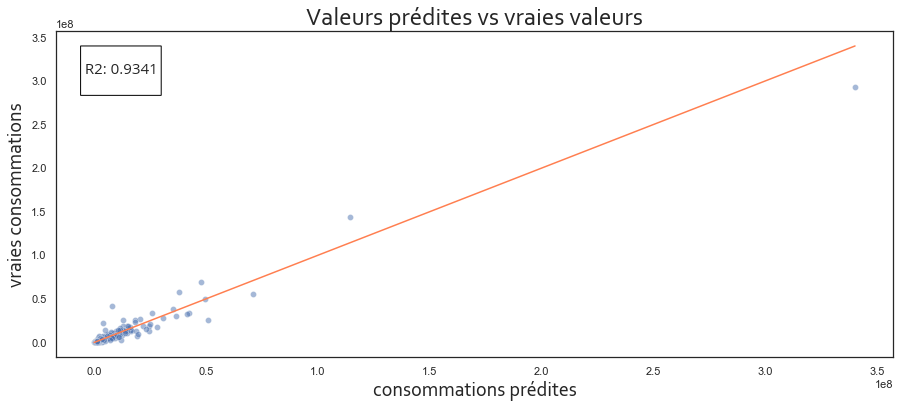

In [245]:
toolbox.plot_test_vs_pred(best_model_gb_star_fit, y_star_test,
                          X_star_test, 'SiteEnergyUse(kBtu)',
                          'consommations', 30_000_000)

<h5 style="font-family:Corbel Light; color:#737373">XGBoost</h5>

In [246]:
space_xgb = {'eta': hp.loguniform('eta', np.log(0.1), np.log(0.7)),
             'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
             'gamma': hp.uniform('gamma', 0, 100),
             # 'reg_lambda' : hp.uniform('reg_lambda', 0, 100),
             'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1300, 1)),
             'subsample': hp.uniform('subsample', 0.7, 1)
             }

trials_xgb = Trials()

print("-R2 sans optimisation : {:.4f}\n".format(xgb_r2_cv({}, X_star_train, y_star_train, transformers_star)))

best_params_xgb_star = fmin(fn=partial(xgb_r2_cv, X=X_star_train, y=y_star_train, transformers=transformers_star),
                            space=space_xgb,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=trials_xgb,
                            rstate=np.random.default_rng(8),
                            # early_stop_fn=no_progress_loss(30)
                            )

-R2 sans optimisation : -0.6906

100%|██████████| 100/100 [03:05<00:00,  1.85s/trial, best loss: -0.7118251627917582]


In [248]:
best_model_xgb_star = xgb.XGBRegressor(seed=8,
                                       max_depth=int(best_params_xgb_star['max_depth']),
                                       eta=best_params_xgb_star['eta'],
                                       colsample_bytree=best_params_xgb_star['colsample_bytree'],
                                       gamma=best_params_xgb_star['gamma'],
                                       # reg_lambda=best_params_xgb_star['reg_lambda'],
                                       n_estimators=int(best_params_xgb_star['n_estimators']),
                                       subsample=best_params_xgb_star['subsample']
                                       )

best_model_xgb_star_fit = toolbox.score_best_model(best_model_xgb_star, transformers_star, best_params_xgb_star, datasets_star)

,Param,Best Param
0,colsample_bytree,0.73452
1,eta,0.28669
2,gamma,0.54157
3,max_depth,4.00000
4,n_estimators,791.00000
5,subsample,0.90346


Modèle optimisé : 
Test R2 : 0.9328
Temps d'entrainement : 1.453
Train R2 : 0.9585

Ecart type R2 (validation croisée sur train set) : 0.0612


In [249]:
print('Rappel : résultats du modèle optimisé sans energy star score')
model_no_star = toolbox.score_best_model(best_model_xgb, transformers, best_params_xgb, datasets)

Rappel : résultats du modèle optimisé sans energy star score


,Param,Best Param
0,colsample_bytree,0.67826
1,eta,0.41188
2,gamma,0.37955
3,max_depth,2.00000
4,n_estimators,1_125.00000
5,subsample,0.97084


Modèle optimisé : 
Test R2 : 0.8809
Temps d'entrainement : 0.942
Train R2 : 0.9544

Ecart type R2 (validation croisée sur train set) : 0.0971


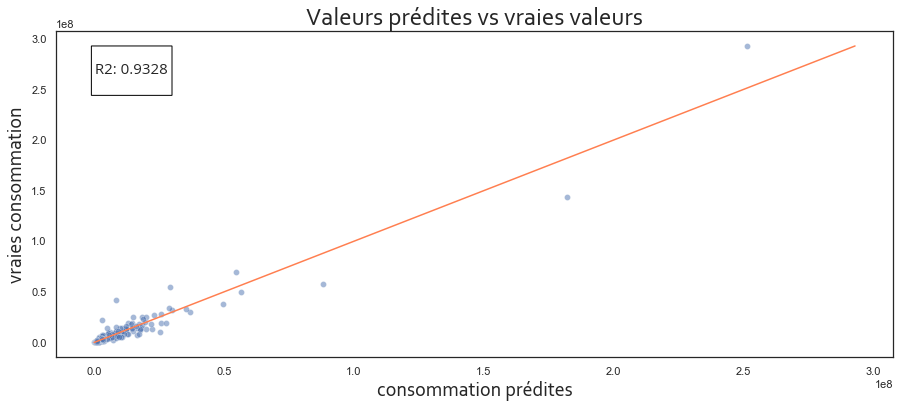

In [250]:
toolbox.plot_test_vs_pred(best_model_xgb_star_fit, y_star_test,
                          X_star_test, 'SiteEnergyUse(kBtu)', 
                          'consommation', 30_000_000)

De tous les modèles testés, le XGBooost avec energy star score optimisé est celui qui a les meilleurs résultats, et surtout l'écart type le plus faible à 0.06 alors que les autres modèles tournent autour de 0.2.

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#e54b87">Conclusion</span></h2>

- Sur la qualité du modèle : On a retenu le modèle Xgboost. Cependant, on a construit notre modèle avec un jeu de données très réduit, il n’est pas très robuste. Lorsque j’ai essayé de le ré-entrainer avec toutes les données, les résultats ont drastiquement chuté. Il aurait sûrement fallu revoir le feature engineering en analysant toutes les données.


- Sur l’utilité de l’energy star score : il permet d'avoir de meilleurs résultats (R2 passe d'une fourchette de [0.78 - 0.98] à [0.87 - 0.99]). Cependant, il nous force à beaucoup réduire le nombre d’observations et donc à perdre beaucoup d’informations. Si en plus le coût pour calculer l'energy star score est élevé, je conseillerai à l’équipe de ne pas l’utiliser pour les prédictions. 